## Unsupervised outlier detection using LSTM + AE from TS data 

- Data Measuring Multiple gases with an environmental sensors  
- Place : the computer center of Soongsil Unv.  
- Time : 2022-05-01 ~ 2022-05-19  
- Feature : TMP ,HMD, TVOC, CO, CO2, CH2O, PM10 (7 features)  

## 0. Setting

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Outlier Detection Paper'
!ls

 영석		 Figure		   oc_svm_model_save
'논문 작업'	'LAB TEST.ipynb'  'Outlier Detection Final.ipynb'
'준혁 옛날 거'	'low version'	   Reference
 data		 lstm_model_save


### Library Call

In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
# 상용 라이브러리
from glob import glob
import os
import pandas as pd
import numpy as np
from datetime import datetime
import time
import pickle

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# Sckit-Learn 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# Statistic Tools 라이브러리
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.cluster.hierarchy import dendrogram, linkage

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras import backend
from functools import partial
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Activation, Flatten, Dense
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [ ]:
# BoxplotEDA Function Definition
def boxplotEDA(data,cols,nrow,ncol,title):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle(title,y=0.92,size=30)
  i=0
  for col in cols:
    sns.boxplot(y = df[col], ax=ax[i//ncol,i%ncol], palette='Set3', linewidth=1.5)
    i+=1  

# Sublineplot
def subplots(data,cols,nrow,ncol,title):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle(title, y=0.92, size=30)
  i=0
  for col in cols:
    ax[i//ncol,i%ncol].plot(df[col])
    ax[i//ncol,i%ncol].set_ylabel(col)
    i+=1  
  
# lineplot
def lineplot(data,cols,title):
  df = data[cols]
  plt.figure(figsize=(20,10))
  plt.title(title, y=1.05, size=25)
  for col in cols:
    plt.plot(df[col], label=col)
  plt.legend(loc='upper right')  

# corr_matrix
def corr_matrix(data, cols, title):
  df = data[cols]
  colormap = plt.cm.PuBu 
  plt.figure(figsize=(12, 12)) 
  plt.title(title, y=1.05, size=20)
  sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
              square = True, cmap = colormap, linecolor = "white", annot = True, fmt='.2f',
              annot_kws = {"size" : 12})
  plt.show()

# IQR Based Outlier Processing Function Definition
def outliers_iqr(data):
  q1,q3 = np.percentile(data,[25,75])
  iqr=q3-q1
  lower_bound=  q1 - (iqr *1.5)
  upper_bound = q3 + (iqr *1.5)
  data[data>upper_bound] = np.nan #np.mean(data)
  data[data<lower_bound] = np.nan #np.mean(data)
  data.interpolate(method="ffill", inplace=True)
  data.interpolate(method="bfill", inplace=True)
  return data

# Reconstruction Error Computation Function
def RE_SCORE(X_input, X_pred):
    score = pd.DataFrame(index = X_pred.index)
    score['RE_SCORE'] = np.mean(np.square(X_input-X_pred),axis=1)
    return score

# Simulation Data Cleansing Function Definition
def simul_cleansing(df):
  df = df[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
  df['TsYMD'] = pd.to_datetime(df['TsYMD'])
  df = df.sort_values('TsYMD')
  df['TsYMD'] = df['TsYMD'].dt.to_period(freq='min')
  df.rename(columns={'TsYMD':'Time'},inplace=True)
  time =df['Time'].apply(lambda x: x.strftime('%Y%m%d%H%M'))
  df.index = df['Time']
  df.drop('Time',axis=1,inplace=True)
  return df

## 1. Data Load

### Device 11

In [ ]:
# glob Function File Loading
filst = sorted(glob('data/*.csv'))
filst

['data/device11_5_1_5_25.csv', 'data/device16_5_1_5_25.csv']

In [ ]:
# Sensor Data Load
device11 = pd.read_csv(filst[0])
device16 = pd.read_csv(filst[1])

In [ ]:
print(device11.shape)
device11.head()

(17090, 17)


DeviceName                              EntityId                TsYMD  \
0  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:01:08   
1  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:03:08   
2  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:05:08   
3  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:07:09   
4  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:09:09   

   CH2O  PM2.5  PM10    TVOC    CO2  Temperature  Humidity  Radioactivity  \
0  25.0   10.0  18.0  1377.0  545.0        23.27     21.45            0.0   
1  25.0   10.0  19.0  1377.0  544.0        20.51     21.46            0.0   
2  25.0   10.0  18.0  1383.0  546.0        21.87     21.46            0.0   
3  25.0   10.0  18.0  1374.0  547.0        21.87     21.48            0.0   
4  25.0   10.0  18.0  1380.0  548.0        21.86     21.48            0.0   

   Sound    CO  Stink   NO2  H2S  NH3  
0   38.0  0.99   0.03  0.01  0.0  0.0  
1   33.0  0.82   0.03  0.01  0.0  0.0  
2   33.0  0.50   0.03  0.01  0.0  0.0  
3   36.0  0.52   0.03  0.01  0.0  0.0  
4   35.0  0.37   0.03  0.01  0.0  0.0

In [ ]:
# Device11 Information
device11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17090 entries, 0 to 17089
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     17090 non-null  object 
 1   EntityId       17090 non-null  object 
 2   TsYMD          17090 non-null  object 
 3   CH2O           17090 non-null  float64
 4   PM2.5          17090 non-null  float64
 5   PM10           17090 non-null  float64
 6   TVOC           17090 non-null  float64
 7   CO2            17090 non-null  float64
 8   Temperature    17090 non-null  float64
 9   Humidity       17090 non-null  float64
 10  Radioactivity  17090 non-null  float64
 11  Sound          17090 non-null  float64
 12  CO             17090 non-null  float64
 13  Stink          17090 non-null  float64
 14  NO2            17090 non-null  float64
 15  H2S            17090 non-null  float64
 16  NH3            17090 non-null  float64
dtypes: float64(14), object(3)
memory usage: 2.2+ MB


In [ ]:
# Device11 Description
device11.describe()

CH2O         PM2.5          PM10          TVOC           CO2  \
count  17090.000000  17090.000000  17090.000000  17090.000000  17090.000000   
mean      28.538268      6.259450     10.744470   2225.640316    549.528672   
std       13.051426      6.034512     11.267901   1069.545831    113.073053   
min        0.000000      0.000000      0.000000      0.000000    400.000000   
25%       22.000000      3.000000      5.000000   1357.000000    450.000000   
50%       28.000000      4.000000      7.000000   2104.500000    547.000000   
75%       35.000000      8.000000     14.000000   2946.000000    624.000000   
max      333.000000     74.000000    137.000000   7034.000000   1476.000000   

        Temperature      Humidity  Radioactivity         Sound            CO  \
count  17090.000000  17090.000000        17090.0  17090.000000  17090.000000   
mean      24.076917     20.231280            0.0     40.425102      0.645453   
std        2.279940      3.350303            0.0      3.729020      0.126773   
min       17.350000      9.660000            0.0     27.000000      0.000000   
25%       22.430000     17.740000            0.0     38.000000      0.560000   
50%       23.860000     20.250000            0.0     41.000000      0.640000   
75%       25.520000     22.100000            0.0     43.000000      0.720000   
max       33.620000     32.040000            0.0     60.000000      1.540000   

              Stink           NO2      H2S      NH3  
count  17090.000000  17090.000000  17090.0  17090.0  
mean       0.027205      0.009879      0.0      0.0  
std        0.004499      0.001091      0.0      0.0  
min        0.000000      0.000000      0.0      0.0  
25%        0.020000      0.010000      0.0      0.0  
50%        0.030000      0.010000      0.0      0.0  
75%        0.030000      0.010000      0.0      0.0  
max        0.030000      0.010000      0.0      0.0

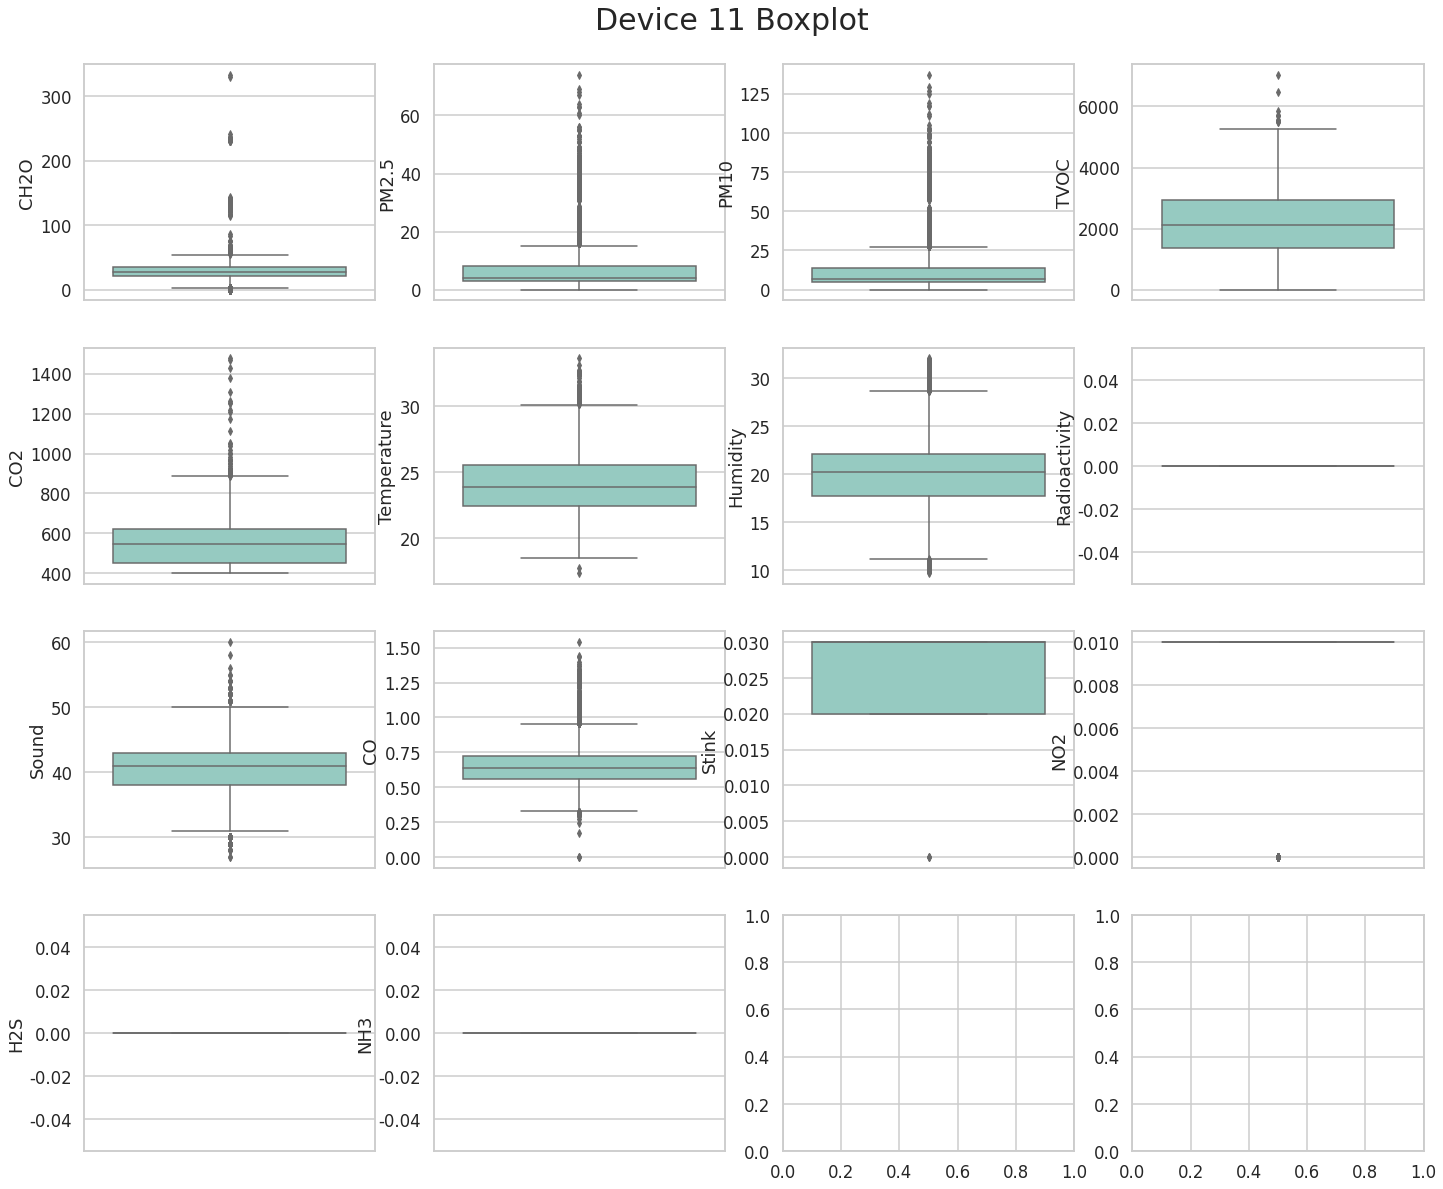

In [ ]:
# Device11 Boxplot
boxplotEDA(device11,device11.columns[3:],4,4,'Device 11 Boxplot')

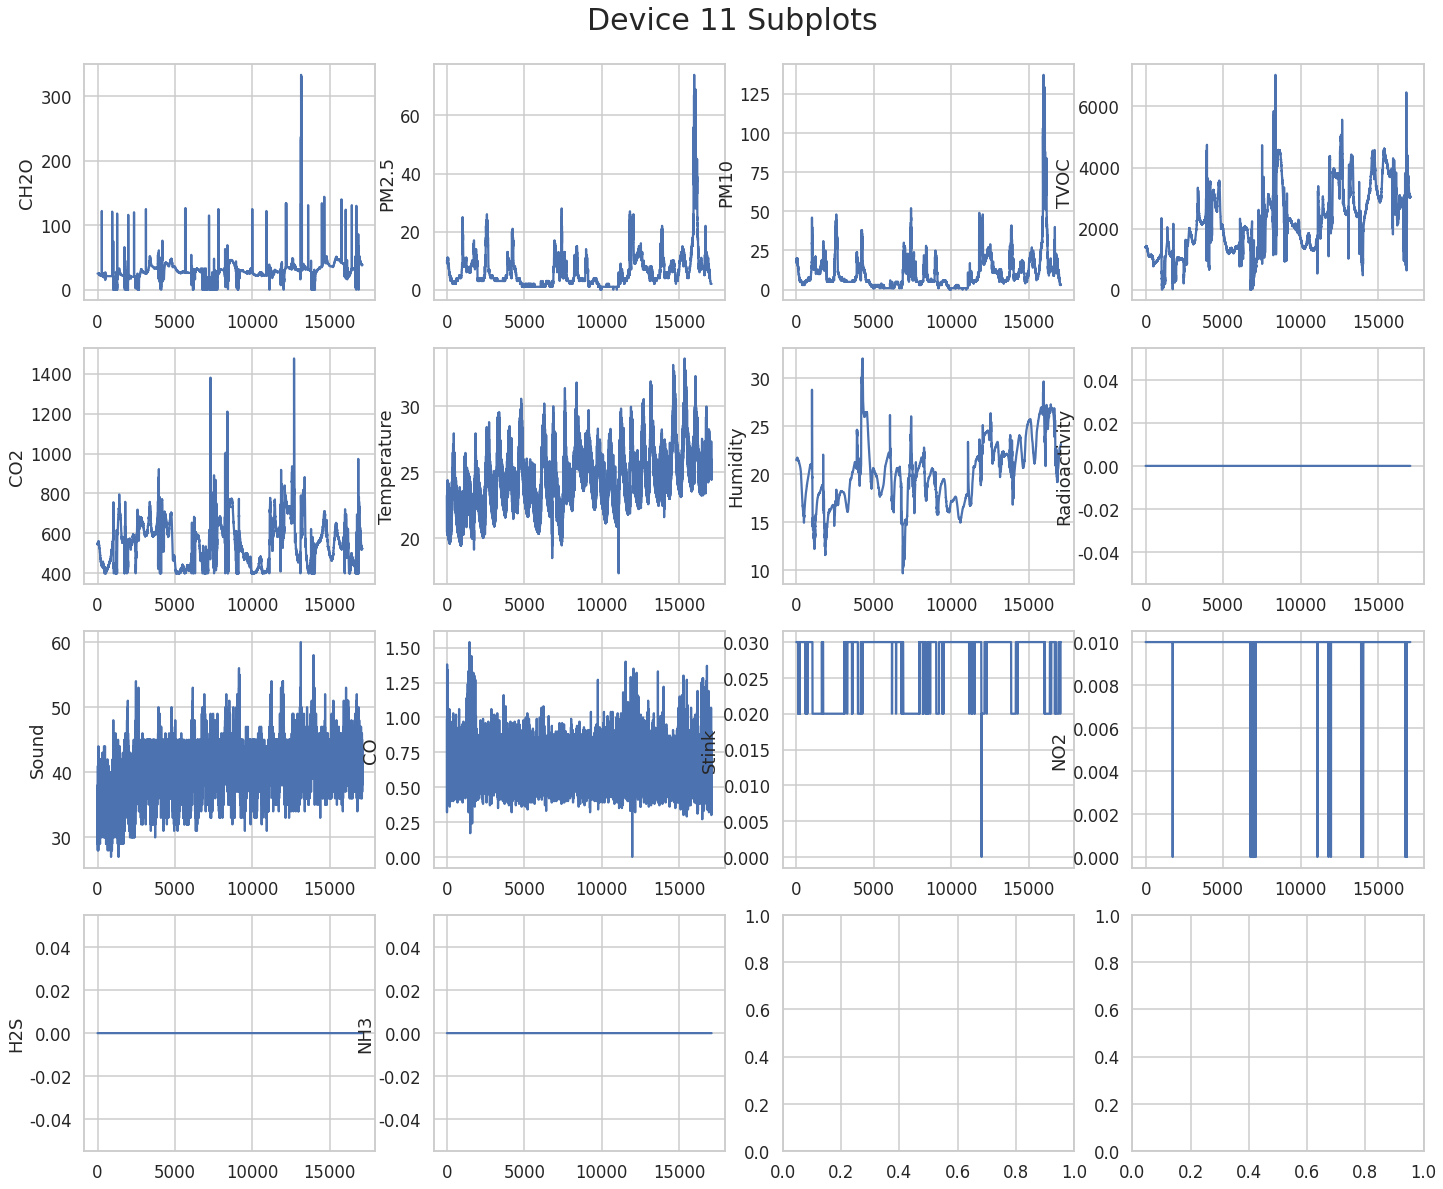

In [ ]:
# Device11 Subplots
subplots(device11,device11.columns[3:],4,4,'Device 11 Subplots')

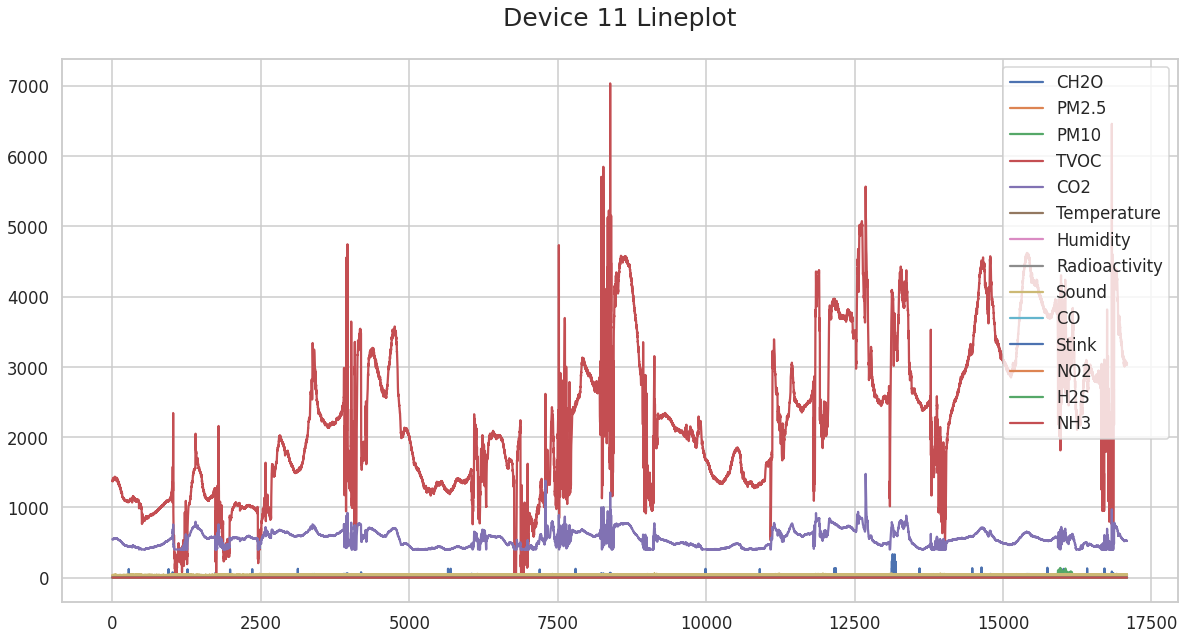

In [ ]:
# Device11 Lineplot
lineplot(device11, device11.columns[3:],'Device 11 Lineplot')

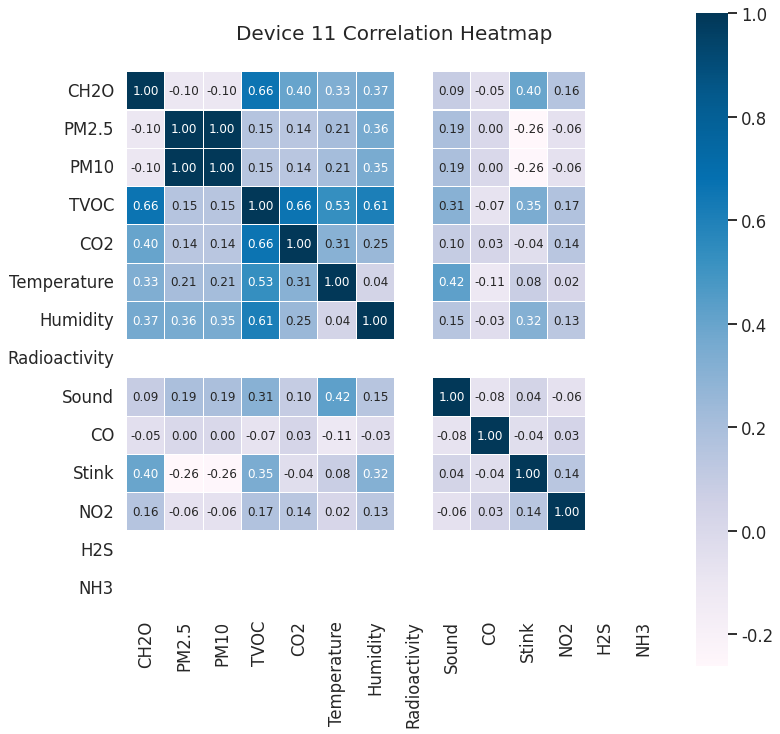

In [ ]:
# Device11 Correlation Heatmap
corr_matrix(device11, device11.columns[3:], 'Device 11 Correlation Heatmap')

### Device 16

In [ ]:
print(device16.shape)
device16.head()

(16954, 17)


DeviceName                              EntityId                TsYMD  \
0  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:01:42   
1  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:03:42   
2  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:05:42   
3  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:07:43   
4  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:09:43   

   CH2O  PM2.5  PM10    TVOC    CO2  Temperature  Humidity  Radioactivity  \
0  41.0   10.0  19.0  1441.0  511.0        21.05     21.64            0.0   
1  41.0   10.0  18.0  1428.0  514.0        23.79     21.64            0.0   
2  41.0    9.0  16.0  1471.0  516.0        22.41     21.64            0.0   
3  41.0   10.0  18.0  1463.0  518.0        21.02     21.63            0.0   
4  41.0   10.0  18.0  1464.0  517.0        22.40     21.66            0.0   

   Sound   CO  Stink  NO2  H2S  NH3  
0   37.0  0.0    0.0  0.0  0.0  0.0  
1   35.0  0.0    0.0  0.0  0.0  0.0  
2   33.0  0.0    0.0  0.0  0.0  0.0  
3   38.0  0.0    0.0  0.0  0.0  0.0  
4   34.0  0.0    0.0  0.0  0.0  0.0

In [ ]:
# Device16 Information
device16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16954 entries, 0 to 16953
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     16954 non-null  object 
 1   EntityId       16954 non-null  object 
 2   TsYMD          16954 non-null  object 
 3   CH2O           16954 non-null  float64
 4   PM2.5          16954 non-null  float64
 5   PM10           16954 non-null  float64
 6   TVOC           16954 non-null  float64
 7   CO2            16954 non-null  float64
 8   Temperature    16954 non-null  float64
 9   Humidity       16954 non-null  float64
 10  Radioactivity  16954 non-null  float64
 11  Sound          16954 non-null  float64
 12  CO             16954 non-null  float64
 13  Stink          16954 non-null  float64
 14  NO2            16954 non-null  float64
 15  H2S            16954 non-null  float64
 16  NH3            16954 non-null  float64
dtypes: float64(14), object(3)
memory usage: 2.2+ MB


In [ ]:
# Device16 Description
device16.describe()

CH2O         PM2.5          PM10          TVOC           CO2  \
count  16954.000000  16954.000000  16954.000000  16954.000000  16954.000000   
mean      48.533915      6.273328     10.713342   2257.573847    543.657839   
std       17.727884      5.210495      9.692058   1145.194732    108.421800   
min       10.000000      1.000000      1.000000      0.000000    400.000000   
25%       37.000000      3.000000      5.000000   1299.250000    443.000000   
50%       46.000000      5.000000      8.000000   2120.000000    545.000000   
75%       60.000000      8.000000     13.000000   3060.000000    616.000000   
max      225.000000     69.000000    127.000000   8611.000000   1311.000000   

        Temperature      Humidity  Radioactivity         Sound            CO  \
count  16954.000000  16954.000000        16954.0  16954.000000  16954.000000   
mean      23.988897     20.907153            0.0     34.675239      0.240119   
std        2.025520      3.186919            0.0      4.719826      0.118233   
min       19.090000     10.950000            0.0     26.000000      0.000000   
25%       22.490000     18.510000            0.0     31.000000      0.210000   
50%       23.830000     20.830000            0.0     34.000000      0.260000   
75%       25.350000     22.790000            0.0     37.000000      0.310000   
max       31.460000     31.270000            0.0     59.000000      0.840000   

              Stink           NO2      H2S           NH3  
count  16954.000000  16954.000000  16954.0  16954.000000  
mean       0.398862      0.008459      0.0      0.278223  
std        0.175390      0.003611      0.0      0.448137  
min        0.000000      0.000000      0.0      0.000000  
25%        0.430000      0.010000      0.0      0.000000  
50%        0.450000      0.010000      0.0      0.000000  
75%        0.470000      0.010000      0.0      1.000000  
max        0.600000      0.010000      0.0      1.000000

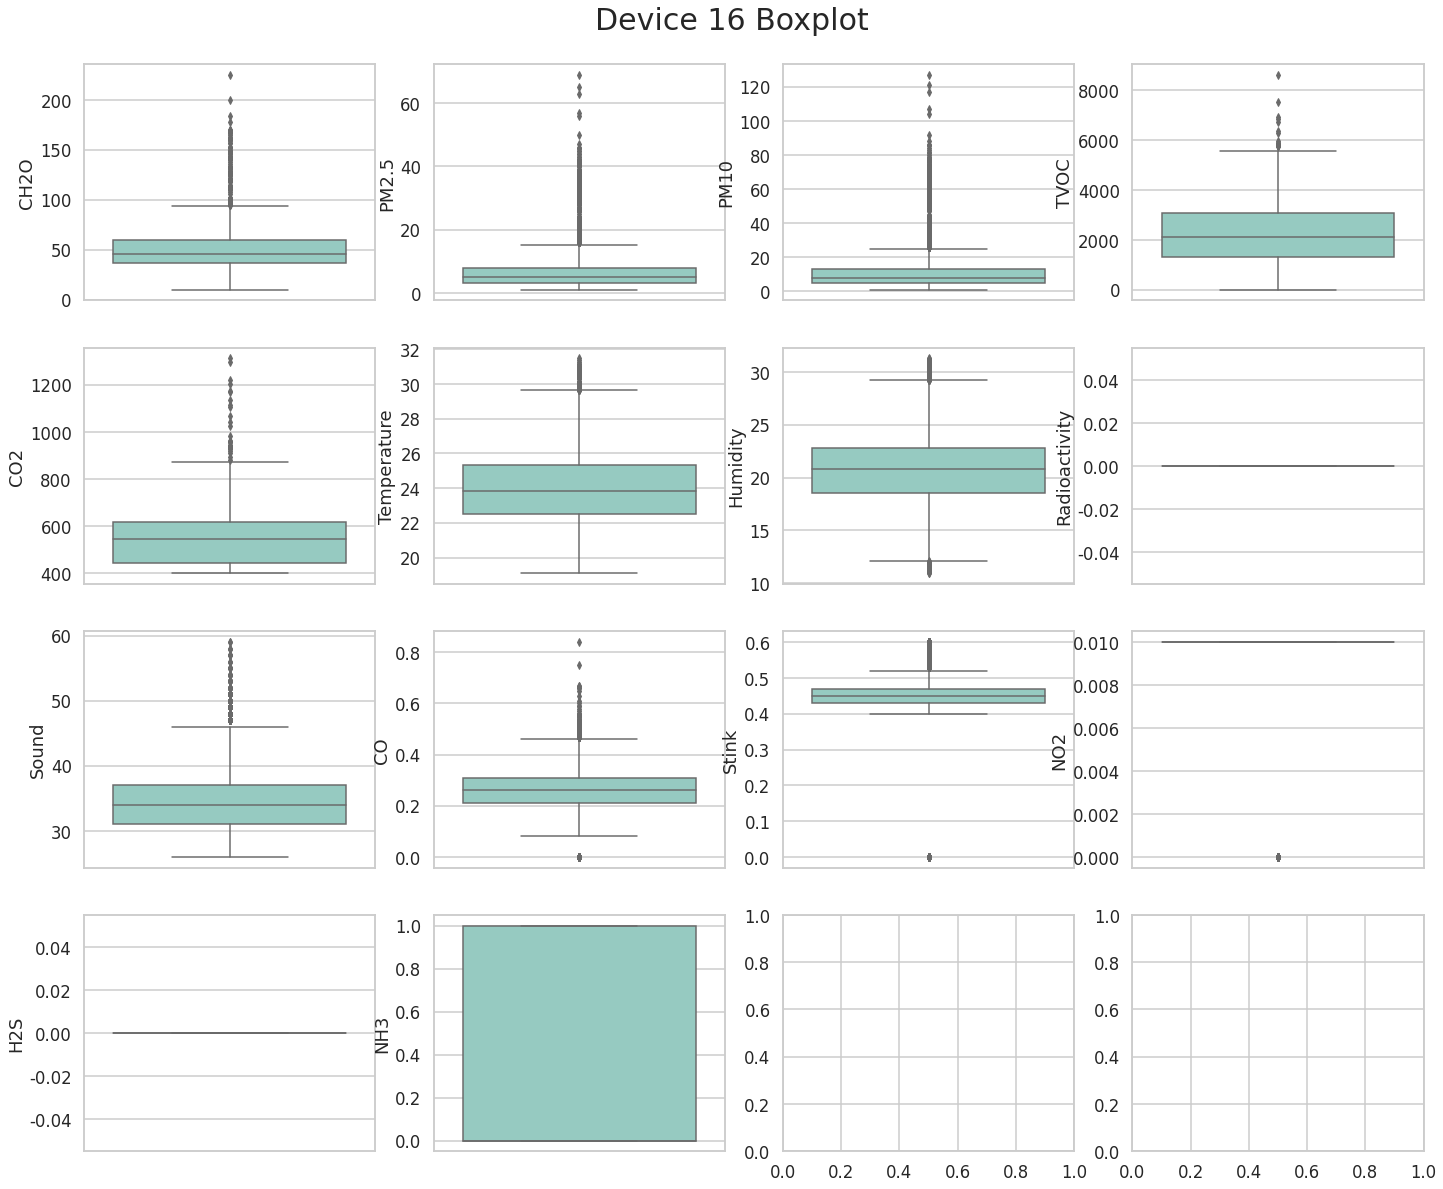

In [ ]:
# Device16 Boxplot
boxplotEDA(device16,device16.columns[3:],4,4,'Device 16 Boxplot')

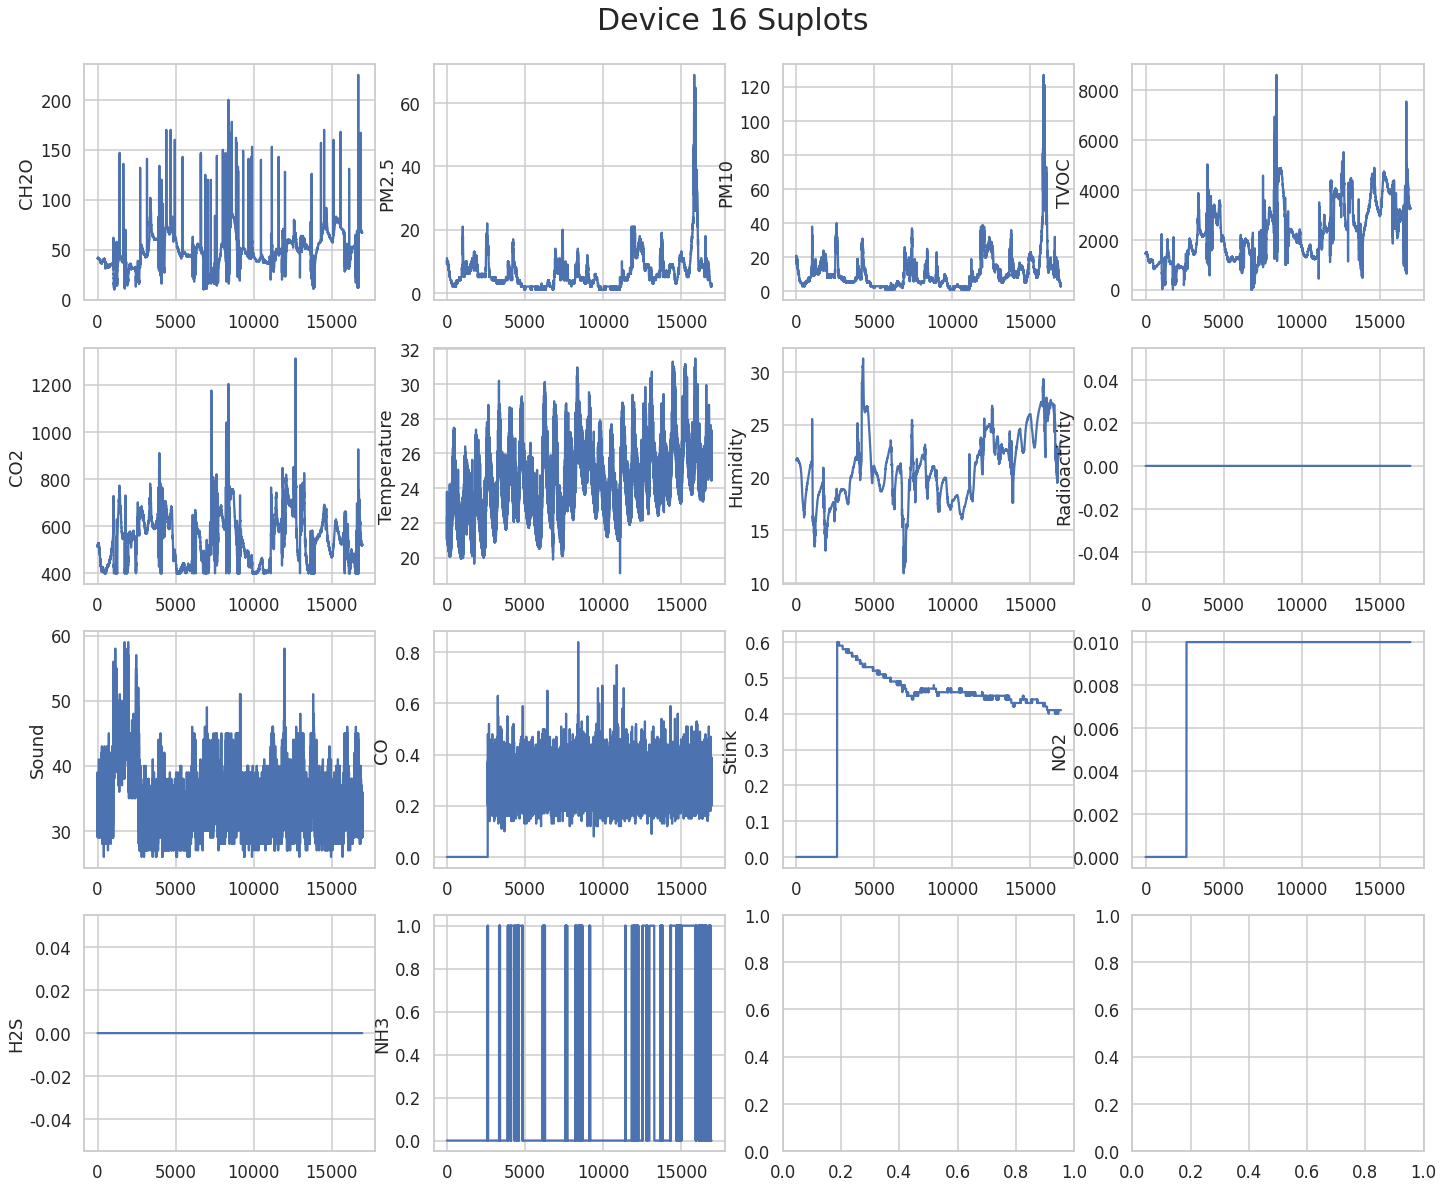

In [ ]:
# Device16 Subplots
subplots(device16,device16.columns[3:],4,4,'Device 16 Suplots')

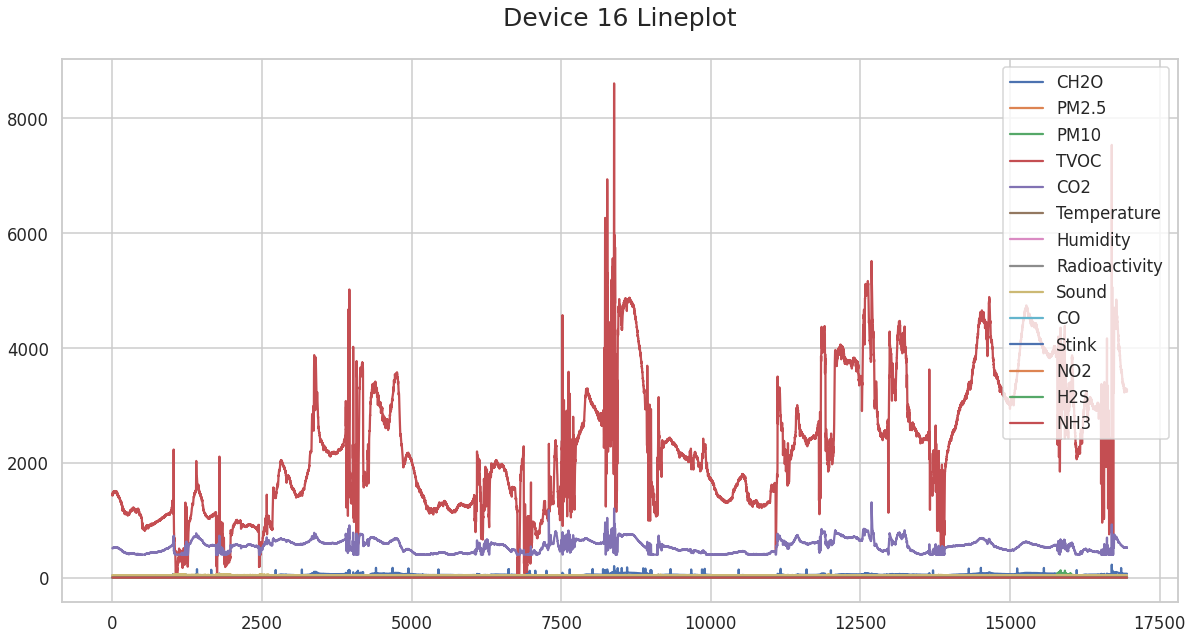

In [ ]:
# Device16 Lineplot
lineplot(device16, device16.columns[3:],'Device 16 Lineplot')

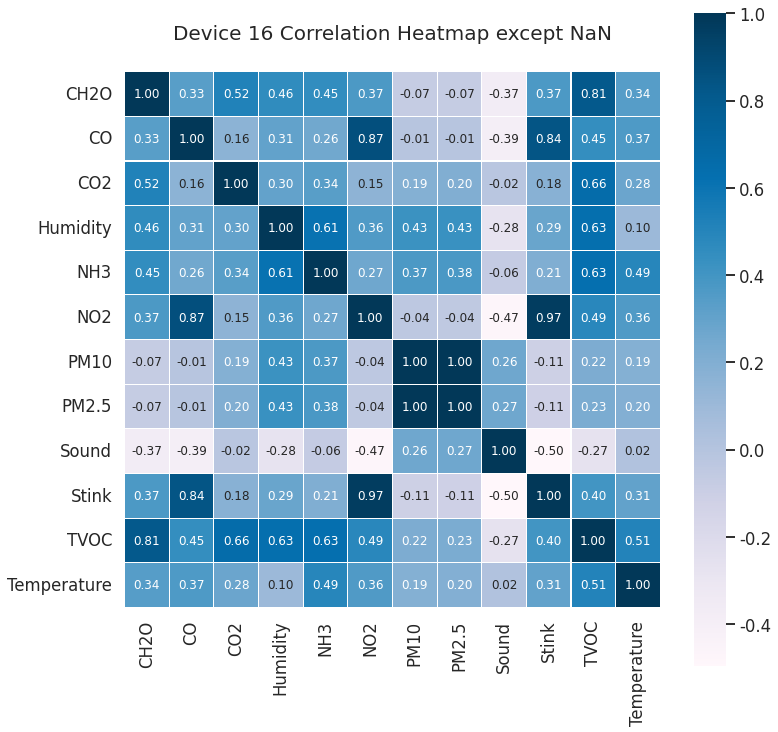

In [ ]:
# Device16 Correlation Heatmap except NaN
corr_matrix(device16, device16.columns[3:].difference(['Radioactivity','H2S']),'Device 16 Correlation Heatmap except NaN')

## 2. Data Prprocessing

### Data Feature Selection

In [ ]:
d11=device11.copy()
d16=device16.copy()

In [ ]:
d11.columns

Index(['DeviceName', 'EntityId', 'TsYMD', 'CH2O', 'PM2.5', 'PM10', 'TVOC',
       'CO2', 'Temperature', 'Humidity', 'Radioactivity', 'Sound', 'CO',
       'Stink', 'NO2', 'H2S', 'NH3'],
      dtype='object')

In [ ]:
# Feature Selection : ['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']
d11 = d11[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
d16 = d16[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
print('d11.shape :',d11.shape)
print('d16.shape :',d16.shape)

d11.shape : (17090, 8)
d16.shape : (16954, 8)


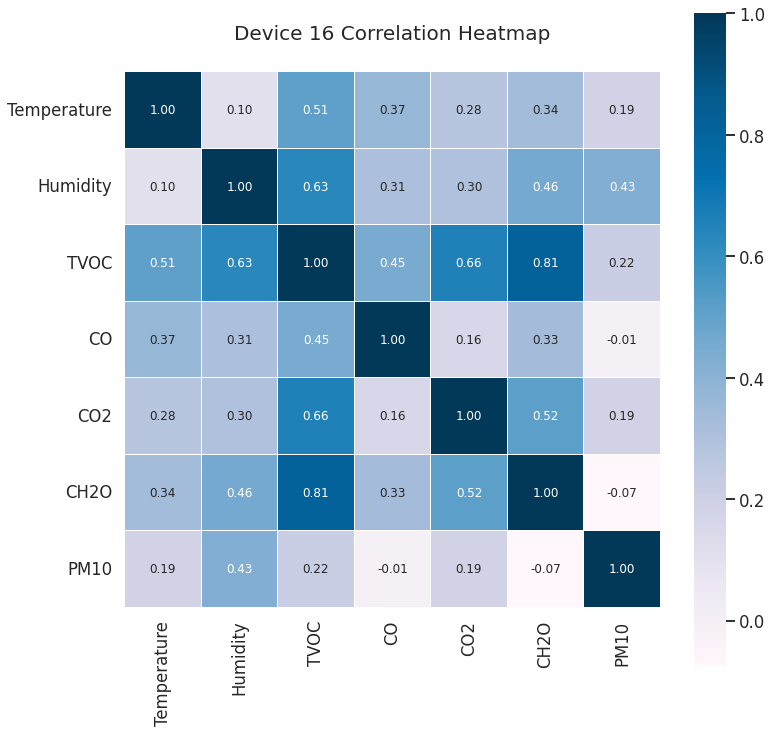

In [ ]:
# Device16 Correlation Heatmap
corr_matrix(d16, d16.columns[1:],'Device 16 Correlation Heatmap')

### Separate device because of long term over 2min


2022-04-13 04:27 | 2022-04-13 10:18 사이 공백 발생  
-> 공백 발생하는 곳마다 여러개의 dataframe으로 나눠 진행 필요

In [ ]:
d11['TsYMD'][4127:4131]
#d16['TsYMD'][8509:8513]

4127    2022-05-06 17:39:54
4128    2022-05-06 17:41:54
4129    2022-05-06 17:43:54
4130    2022-05-06 17:45:54
Name: TsYMD, dtype: object

proceed from here

In [ ]:
d11['TsYMD']=pd.to_datetime(d11['TsYMD'])
d11=d11.sort_values('TsYMD')
d11['TsYMD']=d11['TsYMD'].dt.to_period(freq='min')
time =d11['TsYMD'].apply(lambda x: x.strftime('%Y%m%d%H%M'))
time.head()

0    202205010001
1    202205010003
2    202205010005
3    202205010007
4    202205010009
Name: TsYMD, dtype: object

In [ ]:
check_list=[0]
for i in range(1,len(time)):
  now=datetime.strptime(time[i],'%Y%m%d%H%M')
  past=datetime.strptime(time[i-1],'%Y%m%d%H%M')
  diff=now-past
  diff=diff.seconds/60
  if diff >6:
    check_list.append(i)
check_list.append(len(time))

check_list

[0, 12724, 13035, 13047, 13081, 13128, 17090]

In [ ]:
for i in range(len(check_list)):
  print(d11['TsYMD'][check_list[i]-1:check_list[i]+1])

Series([], Name: TsYMD, dtype: period[T])
12723    2022-05-18 16:21
12724    2022-05-18 18:00
Name: TsYMD, dtype: period[T]
13034    2022-05-19 07:08
13035    2022-05-19 07:17
Name: TsYMD, dtype: period[T]
13046    2022-05-19 07:49
13047    2022-05-19 07:59
Name: TsYMD, dtype: period[T]
13080    2022-05-19 09:21
13081    2022-05-19 09:29
Name: TsYMD, dtype: period[T]
13127    2022-05-19 11:20
13128    2022-05-19 11:53
Name: TsYMD, dtype: period[T]
17089    2022-05-24 23:59
Name: TsYMD, dtype: period[T]


In [ ]:
d11_1=d11[check_list[0]:check_list[1]]
d11_2=d11[check_list[1]+1:check_list[2]]
d11_3=d11[check_list[2]+1:check_list[3]]
d11_4=d11[check_list[3]+1:check_list[4]]
d11_5=d11[check_list[4]+1:check_list[5]]

device11 -> d11_1, d11_2, d11_3, d11_4, d11_5로 나눠 진행

### Time Synchronization (2 min)

In [ ]:
import datetime

def deviceEDA(device):
  device.reset_index(drop=True,inplace=True)
  time =device['TsYMD'].apply(lambda x: x.strftime('%Y%m%d%H%M'))
  time.reset_index(drop=True,inplace=True)
  for i in range(len(device['TsYMD'])):
    if int(time[i][-2:])%2 ==1:
      device['TsYMD'][i]=device['TsYMD'][i]+datetime.timedelta(minutes=1)
  return device

def frameEDA(device):
  frame = pd.date_range(start = device['TsYMD'].iloc[0].strftime('%Y-%m-%d %H:%M'),            # 날짜 범위 시작
                     end = device['TsYMD'].iloc[-1].strftime('%Y-%m-%d %H:%M'),                # 날짜 범위 끝
                     freq = '2min',                           # 시간 간격( 2분 간격)
                     tz = 'Asia/Seoul')                       # 시간대(timezone)
  frame=pd.DataFrame(frame)
  frame.columns=['TsYMD']
  frame['TsYMD'] = frame['TsYMD'].dt.to_period(freq = 'min')  #분까지 끊기
  return frame

def mergeEDA(device,frame):
  merge_device = pd.merge(frame, device, how='outer',on='TsYMD')
  merge_device = merge_device.sort_values('TsYMD')
  merge_device.interpolate(method="ffill", inplace=True)
  return merge_device

def synchronization(device):
  new_device=deviceEDA(device)
  new_device_frame=frameEDA(new_device)
  new_device= mergeEDA(new_device,new_device_frame)
  return new_device

In [ ]:
newd11_1=synchronization(d11_1)
newd11_2=synchronization(d11_2)
newd11_3=synchronization(d11_3)
newd11_4=synchronization(d11_4)
newd11_5=synchronization(d11_5)

In [ ]:
print('-----------------------')
print(len(d11_1))
print(len(newd11_1))
print('-----------------------')
print(len(d11_2))
print(len(newd11_2))
print('-----------------------')
print(len(d11_3))
print(len(newd11_3))
print('-----------------------')
print(len(d11_4))
print(len(newd11_4))
print('-----------------------')
print(len(d11_5))
print(len(newd11_5))
print('-----------------------')

-----------------------
12724
12737
-----------------------
310
396
-----------------------
11
16
-----------------------
33
41
-----------------------
46
55
-----------------------


In [ ]:
d11_1=newd11_1
d11_2=newd11_2
d11_3=newd11_3
d11_4=newd11_4
d11_5=newd11_5

최종 device11 dataframe : d11_1, d11_2, d11_3, d11_4, d11_5

### Data Merge

In [ ]:
df_list = [d11_1,d11_2,d11_3,d11_4,d11_5]
df11 = pd.concat(df_list)
df11.rename(columns={'TsYMD':'Time'},inplace=True)
df11.drop_duplicates(subset=['Time'],inplace=True)
df11.reset_index(inplace=True,drop=True)
df11

Time  Temperature  Humidity    TVOC    CO    CO2  CH2O  \
0      2022-05-01 00:02        23.27     21.45  1377.0  0.99  545.0  25.0   
1      2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0   
2      2022-05-01 00:06        21.87     21.46  1383.0  0.50  546.0  25.0   
3      2022-05-01 00:08        21.87     21.48  1374.0  0.52  547.0  25.0   
4      2022-05-01 00:10        21.86     21.48  1380.0  0.37  548.0  25.0   
...                 ...          ...       ...     ...   ...    ...   ...   
13232  2022-05-19 11:12        28.23     21.03  3772.0  0.72  723.0  34.0   
13233  2022-05-19 11:14        28.23     21.03  3772.0  0.72  723.0  34.0   
13234  2022-05-19 11:16        28.32     21.02  3848.0  0.43  736.0  35.0   
13235  2022-05-19 11:18        28.37     20.99  3860.0  0.55  741.0  35.0   
13236  2022-05-19 11:20        27.05     20.98  3923.0  0.50  743.0  35.0   

       PM10  
0      18.0  
1      19.0  
2      18.0  
3      18.0  
4      18.0  
...     ...  
13232   5.0  
13233   5.0  
13234   5.0  
13235   5.0  
13236   5.0  

[13237 rows x 8 columns]

### Difference

In [ ]:
def adf_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] < pvalue:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.")
    else:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.")

def adf_test1(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       print(timeseries.name,f"정상성이 보장됩니다.")
    else:
       print(timeseries.name,f"정상성을 보장하지 못합니다.")

In [ ]:
adf_test(df11['PM10'])

Results of Dickey-Fuller Test:
Test Statistic                    -5.360388
p-value                            0.000043
Lags Used                         34.000000
Number of Observations Used    13210.000000
Critical Value (1%)               -3.959455
Critical Value (5%)               -3.410822
Critical Value (10%)              -3.127246
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.


In [ ]:
for i in range(7):
  adf_test1(df11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


In the case of 'device11', Normality is satisfied in all areas except CO, NO2, H2S, and NH3.

In [ ]:
diff11=df11.copy()

In [ ]:
# all 1st Difference
for i in range(7):
    diff11.iloc[:,1+i]=diff11.iloc[:,1+i].replace(diff11.iloc[:,1+i].diff().dropna())
for i in range(7):
  adf_test1(diff11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


In [ ]:
diff11

Time  Temperature  Humidity   TVOC    CO  CO2  CH2O  PM10
0      2022-05-01 00:02        23.27     21.45   12.0  0.99  0.0   0.0  -1.0
1      2022-05-01 00:04        20.51     21.46   12.0  0.82  0.0   0.0   0.0
2      2022-05-01 00:06        21.87     21.46    3.0  0.50  2.0   0.0  -1.0
3      2022-05-01 00:08        21.87     21.48   15.0  0.52 -2.0   0.0  -1.0
4      2022-05-01 00:10        21.86     21.48   -2.0  0.37  1.0   0.0  -1.0
...                 ...          ...       ...    ...   ...  ...   ...   ...
13232  2022-05-19 11:12        28.23     21.03    3.0  0.72 -1.0   0.0   1.0
13233  2022-05-19 11:14        28.23     21.03    3.0  0.72 -1.0   0.0   1.0
13234  2022-05-19 11:16        28.32     21.02    1.0  0.43 -1.0   0.0   1.0
13235  2022-05-19 11:18        28.37     20.99    1.0  0.55 -2.0   0.0   1.0
13236  2022-05-19 11:20        27.05     20.98 -201.0  0.50  0.0   0.0   1.0

[13237 rows x 8 columns]

In [ ]:
def diff1(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       timeseries=timeseries
    else:
       timeseries=timeseries.replace(timeseries.diff(1).dropna())
       
def diff2(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       timeseries=timeseries
    else:
       timeseries=timeseries.replace(timeseries.diff().diff().dropna())

In [ ]:
for i in range(7):
    diff1(diff11.iloc[:,1+i])
    diff2(diff11.iloc[:,1+i])
for i in range(7):
    adf_test1(diff11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


### Outlier Process

In [ ]:
# Outlier Processing for 7 Features
for i in range(7):
    outliers_iqr(df11.iloc[:,1+i])

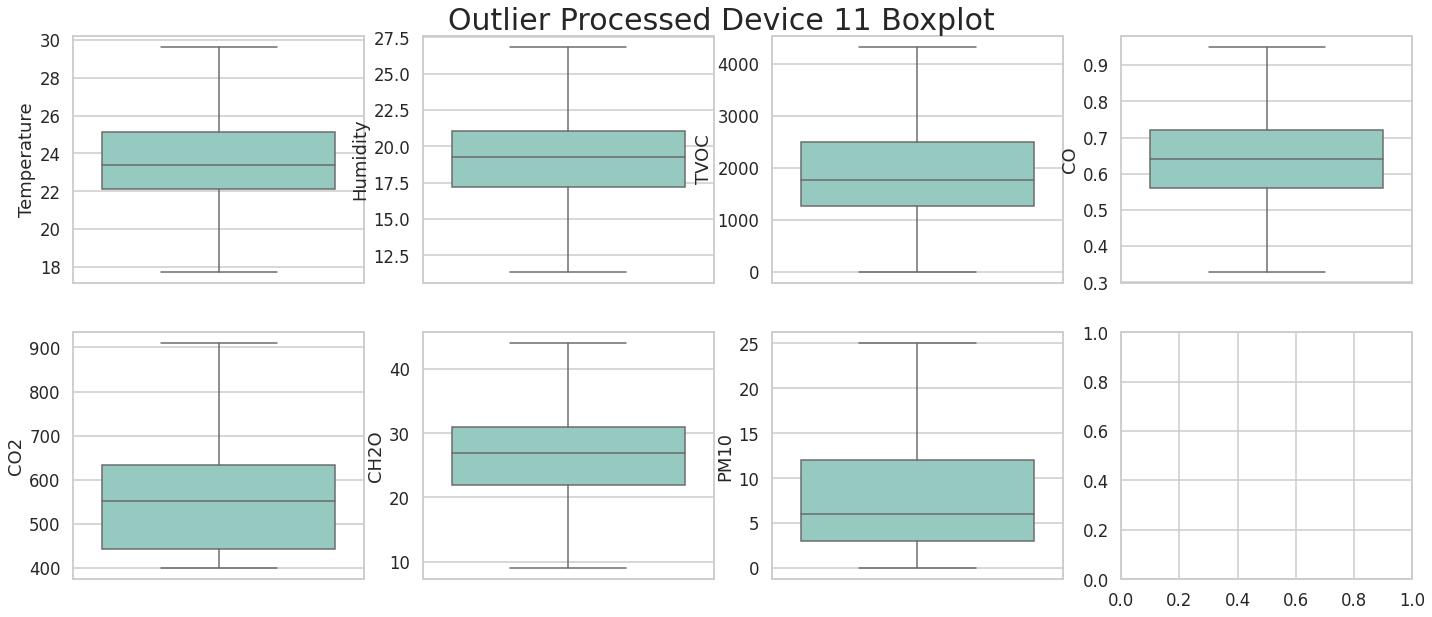

In [ ]:
# Outlier Processed Device 11 Boxplot
boxplotEDA(df11,df11.columns[1:],2,4,'Outlier Processed Device 11 Boxplot')

## 3. Modeling

### Modeling Preparation

In [ ]:
# DataFrame Time Indexing for Time Series Data
df11.set_index('Time',inplace=True)
diff11.set_index('Time',inplace=True)
print('df11 :',df11.shape)
print('diff11 :',diff11.shape)
df11.head()

df11 : (13237, 7)
diff11 : (13237, 7)


Temperature  Humidity    TVOC    CO    CO2  CH2O  PM10
Time                                                                    
2022-05-01 00:02        23.27     21.45  1377.0  0.82  545.0  25.0  18.0
2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0  19.0
2022-05-01 00:06        21.87     21.46  1383.0  0.50  546.0  25.0  18.0
2022-05-01 00:08        21.87     21.48  1374.0  0.52  547.0  25.0  18.0
2022-05-01 00:10        21.86     21.48  1380.0  0.37  548.0  25.0  18.0

In [ ]:
# train_test_split | 0.8 : 0.2
sep = int(df11.shape[0] * 0.8)
X_train = df11.iloc[:sep,:]
X_test = df11.iloc[sep:,:]
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)

# Normalization
norm = MinMaxScaler()
X_train_scaled = norm.fit_transform(X_train)
X_test_scaled = norm.transform(X_test)

# Data Windowing
train = np.reshape(X_train_scaled[:10587],(-1,3,7))
test = np.reshape(X_test_scaled[:2646],(-1,3,7))
print(train.shape)
print(test.shape)     

X_train.shape: (10589, 7)
X_test.shape: (2648, 7)


### LSTM-AE 

<b>Encoder

In [ ]:
# Encoder

encoder_input = keras.layers.Input(shape=(train.shape[1],train.shape[2]))

L1 = LSTM(128, activation='relu', return_sequences=True)(encoder_input)
L2 = LSTM(64, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(L1)
L3 = LSTM(32, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(L2)
L4 = LSTM(4, activation='relu', return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(L3)
L5 = keras.layers.RepeatVector(train.shape[1])(L4)

encoder_output = L5

In [ ]:
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 7)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 128)            69632     
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 3, 32)             12416     
                                                                 
 lstm_3 (LSTM)               (None, 4)                 592       
                                                                 
 repeat_vector (RepeatVector  (None, 3, 4)             0         
 )                                                               
                                                             

<b>Decoder

In [ ]:
# Decoder
decoder_input = keras.layers.Input(shape=(train.shape[1],4))

L6 = LSTM(4, activation='relu', return_sequences=True)(decoder_input)
L7 = LSTM(32, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(L6)
L8 = LSTM(64, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(L7)
L9 = LSTM(128, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(L8)
output = tf.keras.layers.TimeDistributed(Dense(train.shape[2]))(L9)

decoder_output = output

In [ ]:
decoder = keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 4)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 4)              144       
                                                                 
 lstm_5 (LSTM)               (None, 3, 32)             4736      
                                                                 
 lstm_6 (LSTM)               (None, 3, 64)             24832     
                                                                 
 lstm_7 (LSTM)               (None, 3, 128)            98816     
                                                                 
 time_distributed (TimeDistr  (None, 3, 7)             903       
 ibuted)                                                         
                                                           

<b>Connecting Encoder & Decoder

In [ ]:
# LSTM-AE = Encoder + Decoder

encoder_in = keras.layers.Input(shape=(train.shape[1],train.shape[2]))
x = encoder(encoder_in)
decoder_out = decoder(x)

lstm_ae_model = keras.Model(encoder_in,decoder_out)
lstm_ae_model.compile(optimizer='adam', loss='mse')
lstm_ae_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 7)]            0         
                                                                 
 model (Functional)          (None, 3, 4)              132048    
                                                                 
 model_1 (Functional)        (None, 3, 7)              129431    
                                                                 
Total params: 261,479
Trainable params: 261,479
Non-trainable params: 0
_________________________________________________________________


<b> LSTM-AE Model Training

In [ ]:
# Checkpoint Callback Function Definition
checkpoint_dir = 'lstm-ae-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 5번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
# TQDM Tracking LSTN-AE Model Training
nb_epochs = 30
batch_size = 10
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = lstm_ae_model.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history

Training:   0%|           0/30 ETA: ?s,  ?epochs/s

Epoch 1/30


0/336           ETA: ?s - 

Epoch 1/30
335/336 [============================>.] - ETA: 0s - loss: 0.0670
Epoch 1: val_loss improved from inf to 0.02347, saving model to lstm-ae-checkpoint/cp-0001-0.02.ckpt
336/336 [==============================] - 47s 47ms/step - loss: 0.0670 - val_loss: 0.0235
Epoch 2/30


0/336           ETA: ?s - 

Epoch 2/30
335/336 [============================>.] - ETA: 0s - loss: 0.0300
Epoch 2: val_loss improved from 0.02347 to 0.02319, saving model to lstm-ae-checkpoint/cp-0002-0.02.ckpt
336/336 [==============================] - 14s 40ms/step - loss: 0.0300 - val_loss: 0.0232
Epoch 3/30


0/336           ETA: ?s - 

Epoch 3/30
336/336 [==============================] - ETA: 0s - loss: 0.0251
Epoch 3: val_loss improved from 0.02319 to 0.01808, saving model to lstm-ae-checkpoint/cp-0003-0.02.ckpt
336/336 [==============================] - 14s 43ms/step - loss: 0.0251 - val_loss: 0.0181
Epoch 4/30


0/336           ETA: ?s - 

Epoch 4/30
336/336 [==============================] - ETA: 0s - loss: 0.0239
Epoch 4: val_loss improved from 0.01808 to 0.01601, saving model to lstm-ae-checkpoint/cp-0004-0.02.ckpt
336/336 [==============================] - 13s 40ms/step - loss: 0.0239 - val_loss: 0.0160
Epoch 5/30


0/336           ETA: ?s - 

Epoch 5/30
335/336 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 5: val_loss improved from 0.01601 to 0.01479, saving model to lstm-ae-checkpoint/cp-0005-0.01.ckpt
336/336 [==============================] - 13s 40ms/step - loss: 0.0226 - val_loss: 0.0148
Epoch 6/30


0/336           ETA: ?s - 

Epoch 6/30
335/336 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 6: val_loss improved from 0.01479 to 0.01442, saving model to lstm-ae-checkpoint/cp-0006-0.01.ckpt
336/336 [==============================] - 14s 42ms/step - loss: 0.0220 - val_loss: 0.0144
Epoch 7/30


0/336           ETA: ?s - 

Epoch 7/30
336/336 [==============================] - ETA: 0s - loss: 0.0210
Epoch 7: val_loss improved from 0.01442 to 0.01314, saving model to lstm-ae-checkpoint/cp-0007-0.01.ckpt
336/336 [==============================] - 14s 40ms/step - loss: 0.0210 - val_loss: 0.0131
Epoch 8/30


0/336           ETA: ?s - 

Epoch 8/30
336/336 [==============================] - ETA: 0s - loss: 0.0203
Epoch 8: val_loss improved from 0.01314 to 0.01161, saving model to lstm-ae-checkpoint/cp-0008-0.01.ckpt
336/336 [==============================] - 26s 79ms/step - loss: 0.0203 - val_loss: 0.0116
Epoch 9/30


0/336           ETA: ?s - 

Epoch 9/30
335/336 [============================>.] - ETA: 0s - loss: 0.0195
Epoch 9: val_loss did not improve from 0.01161
336/336 [==============================] - 17s 50ms/step - loss: 0.0194 - val_loss: 0.0130
Epoch 10/30


0/336           ETA: ?s - 

Epoch 10/30
336/336 [==============================] - ETA: 0s - loss: 0.0189
Epoch 10: val_loss did not improve from 0.01161
336/336 [==============================] - 13s 39ms/step - loss: 0.0189 - val_loss: 0.0148
Epoch 11/30


0/336           ETA: ?s - 

Epoch 11/30
335/336 [============================>.] - ETA: 0s - loss: 0.0182
Epoch 11: val_loss improved from 0.01161 to 0.00841, saving model to lstm-ae-checkpoint/cp-0011-0.01.ckpt
336/336 [==============================] - 13s 40ms/step - loss: 0.0182 - val_loss: 0.0084
Epoch 12/30


0/336           ETA: ?s - 

Epoch 12/30
336/336 [==============================] - ETA: 0s - loss: 0.0169
Epoch 12: val_loss did not improve from 0.00841
336/336 [==============================] - 13s 39ms/step - loss: 0.0169 - val_loss: 0.0084
Epoch 13/30


0/336           ETA: ?s - 

Epoch 13/30
336/336 [==============================] - ETA: 0s - loss: 0.0165
Epoch 13: val_loss improved from 0.00841 to 0.00772, saving model to lstm-ae-checkpoint/cp-0013-0.01.ckpt
336/336 [==============================] - 13s 40ms/step - loss: 0.0165 - val_loss: 0.0077
Epoch 14/30


0/336           ETA: ?s - 

Epoch 14/30
335/336 [============================>.] - ETA: 0s - loss: 0.0156
Epoch 14: val_loss improved from 0.00772 to 0.00689, saving model to lstm-ae-checkpoint/cp-0014-0.01.ckpt
336/336 [==============================] - 13s 40ms/step - loss: 0.0156 - val_loss: 0.0069
Epoch 15/30


0/336           ETA: ?s - 

Epoch 15/30
335/336 [============================>.] - ETA: 0s - loss: 0.0153
Epoch 15: val_loss did not improve from 0.00689
336/336 [==============================] - 14s 42ms/step - loss: 0.0153 - val_loss: 0.0092
Epoch 16/30


0/336           ETA: ?s - 

Epoch 16/30
336/336 [==============================] - ETA: 0s - loss: 0.0151
Epoch 16: val_loss did not improve from 0.00689
336/336 [==============================] - 13s 38ms/step - loss: 0.0151 - val_loss: 0.0098
Epoch 17/30


0/336           ETA: ?s - 

Epoch 17/30
336/336 [==============================] - ETA: 0s - loss: 0.0157
Epoch 17: val_loss did not improve from 0.00689
336/336 [==============================] - 13s 39ms/step - loss: 0.0157 - val_loss: 0.0075
Epoch 18/30


0/336           ETA: ?s - 

Epoch 18/30
336/336 [==============================] - ETA: 0s - loss: 0.0147
Epoch 18: val_loss did not improve from 0.00689
336/336 [==============================] - 13s 39ms/step - loss: 0.0147 - val_loss: 0.0073
Epoch 19/30


0/336           ETA: ?s - 

Epoch 19/30
335/336 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 19: val_loss did not improve from 0.00689
336/336 [==============================] - 13s 40ms/step - loss: 0.0150 - val_loss: 0.0100
Epoch 20/30


0/336           ETA: ?s - 

Epoch 20/30
336/336 [==============================] - ETA: 0s - loss: 0.0152
Epoch 20: val_loss did not improve from 0.00689
336/336 [==============================] - 13s 40ms/step - loss: 0.0152 - val_loss: 0.0091
Epoch 21/30


0/336           ETA: ?s - 

Epoch 21/30
336/336 [==============================] - ETA: 0s - loss: 0.0140
Epoch 21: val_loss did not improve from 0.00689
336/336 [==============================] - 13s 39ms/step - loss: 0.0140 - val_loss: 0.0080
Epoch 22/30


0/336           ETA: ?s - 

Epoch 22/30
336/336 [==============================] - ETA: 0s - loss: 0.0140
Epoch 22: val_loss did not improve from 0.00689
336/336 [==============================] - 13s 40ms/step - loss: 0.0140 - val_loss: 0.0086
Epoch 23/30


0/336           ETA: ?s - 

Epoch 23/30
336/336 [==============================] - ETA: 0s - loss: 0.0140
Epoch 23: val_loss did not improve from 0.00689
336/336 [==============================] - 15s 43ms/step - loss: 0.0140 - val_loss: 0.0077
Epoch 24/30


0/336           ETA: ?s - 

Epoch 24/30
335/336 [============================>.] - ETA: 0s - loss: 0.0136
Epoch 24: val_loss did not improve from 0.00689
336/336 [==============================] - 13s 39ms/step - loss: 0.0136 - val_loss: 0.0081


<b> LSTM-AE Model Save & Load

In [ ]:
# LSTM-AE 모델 저장
lstm_ae_model.save('lstm_model_save/lstm_ae_0712_t3/')

# encoder 모델 저장
encoder.save('lstm_model_save/encoder_0712_t3/')

# decoder 모델 저장
decoder.save('lstm_model_save/decoder_0712_t3/')

INFO:tensorflow:Assets written to: lstm_model_save/lstm_ae_0712_t3/assets


INFO:tensorflow:Assets written to: lstm_model_save/encoder_0712_t3/assets


INFO:tensorflow:Assets written to: lstm_model_save/encoder_0712_t3/assets


INFO:tensorflow:Assets written to: lstm_model_save/decoder_0712_t3/assets


INFO:tensorflow:Assets written to: lstm_model_save/decoder_0712_t3/assets


In [ ]:
# Model Load
lstm_ae_model = keras.models.load_model('lstm_model_save/lstm_ae_0712_t3/')
encoder = keras.models.load_model('lstm_model_save/encoder_0712_t3/')
decoder = keras.models.load_model('lstm_model_save/decoder_0712_t3/')

<b>Model Performance Evaluation

Text(0.5, 1.0, 'Loss Curves')

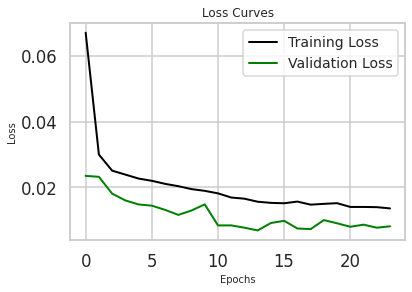

In [ ]:
# Loss curve of the training_set
plt.figure(figsize=[6,4])
plt.plot(history['loss'], 'black', linewidth=2.0)
plt.plot(history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
# Original Train Scaled DataSet
og_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
og_train.index = X_train.index
og_train.head()

Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.428571  0.651133  0.317867  0.790323  0.285996   
2022-05-01 00:04     0.180593  0.651780  0.317867  0.790323  0.284024   
2022-05-01 00:06     0.302785  0.651780  0.319252  0.274194  0.287968   
2022-05-01 00:08     0.302785  0.653074  0.317175  0.306452  0.289941   
2022-05-01 00:10     0.301887  0.653074  0.318560  0.064516  0.291913   

                      CH2O  PM10  
Time                              
2022-05-01 00:02  0.457143  0.72  
2022-05-01 00:04  0.457143  0.76  
2022-05-01 00:06  0.457143  0.72  
2022-05-01 00:08  0.457143  0.72  
2022-05-01 00:10  0.457143  0.72

In [ ]:
# Prediction of Train DataSet
X_pred_train = lstm_ae_model.predict(train)

train_pred = X_pred_train.reshape(-1, X_pred_train.shape[2])
train_pred = pd.DataFrame(train_pred, columns = X_train.columns)
train_pred.index = X_train[:10587].index
print('train_pred.shape :',train_pred.shape)
train_pred.head()

train_pred.shape : (10587, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.250647  0.663321  0.321837  0.532233  0.355294   
2022-05-01 00:04     0.241305  0.670253  0.324374  0.563828  0.330327   
2022-05-01 00:06     0.235581  0.665541  0.327482  0.559875  0.315911   
2022-05-01 00:08     0.252367  0.676426  0.327710  0.532352  0.362927   
2022-05-01 00:10     0.244265  0.685723  0.330351  0.561612  0.336140   

                      CH2O      PM10  
Time                                  
2022-05-01 00:02  0.318805  0.673430  
2022-05-01 00:04  0.336323  0.690838  
2022-05-01 00:06  0.346018  0.694892  
2022-05-01 00:08  0.319938  0.690620  
2022-05-01 00:10  0.335355  0.706352

In [ ]:
# Train data Reconstruction Error
train_score = RE_SCORE(X_train_scaled[:10587], train_pred)
train_score = train_score.set_index(train_score.index)
train_score.head()

RE_SCORE
Time                      
2022-05-01 00:02  0.017791
2022-05-01 00:04  0.010985
2022-05-01 00:06  0.014307
2022-05-01 00:08  0.011321
2022-05-01 00:10  0.038372

In [ ]:
# Train Data Reconstruction Error Threshold
upper, lower= np.quantile(train_score['RE_SCORE'].values,0.75), np.quantile(train_score['RE_SCORE'].values,0.25)
iqr = upper-lower
train_boundary = upper + iqr*1.5
print('Train Data IQR Based boundary :',np.round(train_boundary,4))

Train Data IQR Based boundary : 0.0315


In [ ]:
train_score['Threshold'] = train_boundary
train_score.head()

RE_SCORE  Threshold
Time                                 
2022-05-01 00:02  0.017791   0.031509
2022-05-01 00:04  0.010985   0.031509
2022-05-01 00:06  0.014307   0.031509
2022-05-01 00:08  0.011321   0.031509
2022-05-01 00:10  0.038372   0.031509

In [ ]:
# Reconstruction Error of Train Set
fig = px.scatter(train_score, x=train_score.index, y='RE_SCORE', title='Reconstruction Error of Train Set')
fig.add_trace(go.Scatter(x=train_score.index, y=train_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color=('rgb(237,37,75)'))))

In [ ]:
# Reconstruction Error Distribution of Train Set
fig = px.histogram(train_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Train Set', marginal='box')
fig.add_vline(x=train_boundary, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(train_boundary,4)), annotation_position="bottom right")
fig.show()

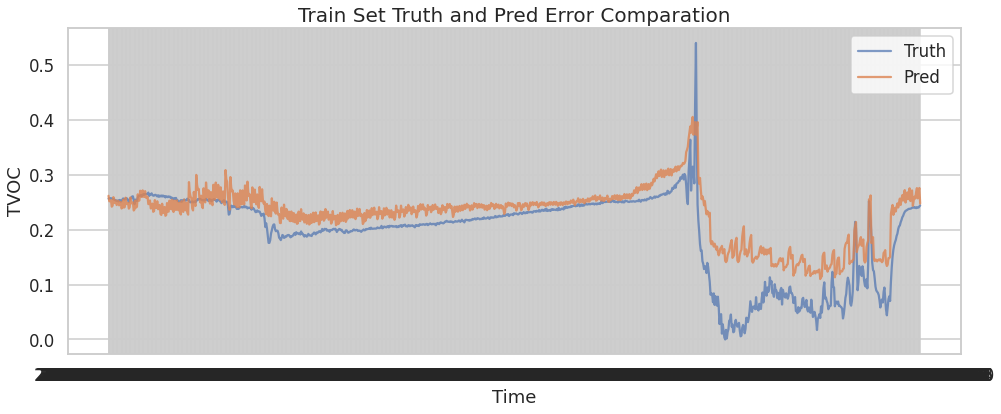

In [ ]:
# Train Set Truth and Pred Error Comparation
plt.figure(figsize=(16,6))
sns.lineplot(og_train.index[300:1300], og_train['TVOC'][300:1300], alpha=0.7, label='Truth')
sns.lineplot(train_pred.index[300:1300], train_pred['TVOC'][300:1300], alpha=0.8, label='Pred')
plt.title('Train Set Truth and Pred Error Comparation',size=20)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Test Set evaluation
lstm_ae_model.evaluate(test,test)

28/28 [==============================] - 2s 7ms/step - loss: 0.0280


0.027978960424661636

In [ ]:
# Original Test DataSet
og_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)
og_test.index = X_test.index
og_test.head()

Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-15 17:00     0.726864  0.248544  0.378347  0.822581  0.092702   
2022-05-15 17:02     0.601078  0.248544  0.375577  0.387097  0.092702   
2022-05-15 17:04     0.600180  0.247896  0.379963  0.451613  0.094675   
2022-05-15 17:06     0.599281  0.248544  0.375577  0.483871  0.098619   
2022-05-15 17:08     0.721473  0.247896  0.373500  0.483871  0.092702   

                      CH2O  PM10  
Time                              
2022-05-15 17:00  0.400000  0.04  
2022-05-15 17:02  0.400000  0.04  
2022-05-15 17:04  0.428571  0.04  
2022-05-15 17:06  0.457143  0.04  
2022-05-15 17:08  0.457143  0.04

In [ ]:
# Prediction of Test Set
X_pred_test = lstm_ae_model.predict(test)

test_pred = X_pred_test.reshape(-1, X_pred_test.shape[2])
test_pred = pd.DataFrame(test_pred, columns = X_test.columns)
test_pred.index = og_test[:-2].index
print('test_pred.shape :',test_pred.shape)
test_pred.head()

test_pred.shape : (2646, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-15 17:00     0.614770  0.323925  0.330374  0.498808  0.126000   
2022-05-15 17:02     0.618605  0.305631  0.313265  0.481353  0.102472   
2022-05-15 17:04     0.602836  0.313593  0.306095  0.473601  0.093869   
2022-05-15 17:06     0.597577  0.333598  0.333318  0.497044  0.122727   
2022-05-15 17:08     0.595829  0.318292  0.316057  0.480248  0.095709   

                      CH2O      PM10  
Time                                  
2022-05-15 17:00  0.433330  0.142761  
2022-05-15 17:02  0.419081  0.127374  
2022-05-15 17:04  0.414566  0.121501  
2022-05-15 17:06  0.442845  0.132659  
2022-05-15 17:08  0.431955  0.117375

In [ ]:
# Test Set reconstruction error
test_score = RE_SCORE(og_test, test_pred)
test_score = test_score.set_index(test_score.index)
test_score.head()

RE_SCORE
Time                      
2022-05-15 17:00  0.019737
2022-05-15 17:02  0.003490
2022-05-15 17:04  0.002443
2022-05-15 17:06  0.002653
2022-05-15 17:08  0.004384

In [ ]:
# Train Data Reconstruction Error Threshold
upper, lower= np.quantile(test_score['RE_SCORE'].values,0.75), np.quantile(test_score['RE_SCORE'].values,0.25)
iqr = upper-lower
test_boundary = upper + iqr*1.5
print('Test Data IQR Based boundary :',np.round(test_boundary,4))

Test Data IQR Based boundary : 0.0812


In [ ]:
test_score['Threshold'] = test_boundary
test_score.head()

RE_SCORE  Threshold
Time                                 
2022-05-15 17:00  0.019737   0.081183
2022-05-15 17:02  0.003490   0.081183
2022-05-15 17:04  0.002443   0.081183
2022-05-15 17:06  0.002653   0.081183
2022-05-15 17:08  0.004384   0.081183

In [ ]:
# Reconstruction Error of Test Set
fig = px.scatter(test_score, x=test_score.index, y='RE_SCORE', title='Reconstruction Error of Test Set')
fig.add_trace(go.Scatter(x=test_score.index, y=test_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color=('rgb(237,37,75)'))))

In [ ]:
# Reconstruction Error Distribution of Test Set
fig = px.histogram(test_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Test Set', marginal='box')
fig.add_vline(x=test_boundary, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(test_boundary,4)), annotation_position="bottom right")
fig.show()

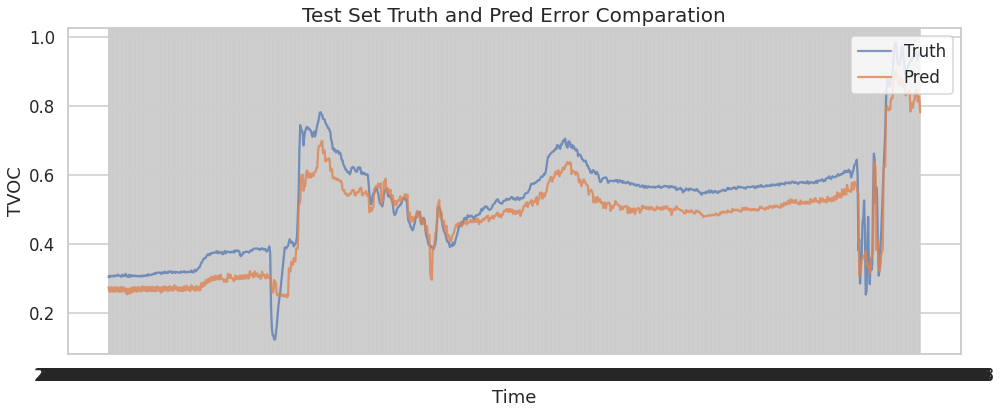

In [ ]:
# Test Set Truth and Pred Error Comparation
plt.figure(figsize=(16,6))
sns.lineplot(og_test.index[300:1300], og_test['TVOC'][300:1300], alpha=0.7, label='Truth')
sns.lineplot(test_pred.index[300:1300], test_pred['TVOC'][300:1300], alpha=0.8, label='Pred')
plt.title('Test Set Truth and Pred Error Comparation',size=20)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Total_score DataFrame Definition
total_score = train_score.copy()
total_score = pd.concat([total_score, test_score])
total_score.drop('Threshold',axis=1,inplace=True)

In [ ]:
# Train Data Reconstruction Error Threshold
upper, lower= np.quantile(total_score['RE_SCORE'].values,0.75), np.quantile(total_score['RE_SCORE'].values,0.25)
iqr = upper-lower
total_boundary = upper + iqr*1.5
print('Total Data IQR Based boundary :',np.round(total_boundary,4))

Total Data IQR Based boundary : 0.0377


In [ ]:
# Anomaly Detection
total_score['Threshold'] = total_boundary
total_score['Anomaly'] = total_score['RE_SCORE'] > total_score['Threshold']
print('total_score.shape :',total_score.shape)
total_score.head()

total_score.shape : (13233, 3)


RE_SCORE  Threshold  Anomaly
Time                                          
2022-05-01 00:02  0.017791   0.037741    False
2022-05-01 00:04  0.010985   0.037741    False
2022-05-01 00:06  0.014307   0.037741    False
2022-05-01 00:08  0.011321   0.037741    False
2022-05-01 00:10  0.038372   0.037741     True

In [ ]:
total_score['Anomaly'].value_counts()

False    12260
True       973
Name: Anomaly, dtype: int64

In [ ]:
fig = px.scatter(total_score, x=total_score.index, y='RE_SCORE', title='Total Reconstruction Error & Threshold')
fig.add_trace(go.Scatter(x=total_score.index, y=total_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color=('rgb(237,37,75)'))))
fig.show()

In [ ]:
fig = px.histogram(total_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Total DataSet', marginal='box')
fig.add_vline(x=total_boundary, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(total_boundary,4)), annotation_position="bottom right")
fig.show()

### Deep Compact Clustering

<b> Normal Data Extraction

In [ ]:
train_set = pd.concat([pd.DataFrame(X_train_scaled,columns=X_train.columns,index=X_train.index),train_score],axis=1)
print('train_set.shape :',train_set.shape)
train_set.head(2)

train_set.shape : (10589, 9)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.428571  0.651133  0.317867  0.790323  0.285996   
2022-05-01 00:04     0.180593  0.651780  0.317867  0.790323  0.284024   

                      CH2O  PM10  RE_SCORE  Threshold  
Time                                                   
2022-05-01 00:02  0.457143  0.72  0.017791   0.031509  
2022-05-01 00:04  0.457143  0.76  0.010985   0.031509

In [ ]:
Threshold = train_boundary
normal = train_set[train_set['RE_SCORE'] <= Threshold]
print('normal.shape :',normal.shape)
normal.head(2)

normal.shape : (10042, 9)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.428571  0.651133  0.317867  0.790323  0.285996   
2022-05-01 00:04     0.180593  0.651780  0.317867  0.790323  0.284024   

                      CH2O  PM10  RE_SCORE  Threshold  
Time                                                   
2022-05-01 00:02  0.457143  0.72  0.017791   0.031509  
2022-05-01 00:04  0.457143  0.76  0.010985   0.031509

In [ ]:
normal_data = normal.drop(['RE_SCORE','Threshold'],axis=1).to_numpy()[:10035].reshape(-1,3,7)
normal_data.shape

(3345, 3, 7)

<b> Embedded Feature Extraction

In [ ]:
embedded = pd.DataFrame(encoder.predict(normal_data).reshape(-1,4))
embedded.head(10)

0         1         2         3
0  0.471057  0.214525  0.138740  0.067758
1  0.471057  0.214525  0.138740  0.067758
2  0.471057  0.214525  0.138740  0.067758
3  0.413232  0.214100  0.138652  0.072008
4  0.413232  0.214100  0.138652  0.072008
5  0.413232  0.214100  0.138652  0.072008
6  0.320039  0.215441  0.144743  0.081650
7  0.320039  0.215441  0.144743  0.081650
8  0.320039  0.215441  0.144743  0.081650
9  0.467815  0.212282  0.133365  0.066570

In [ ]:
embedded = embedded.iloc[:,[0,2]].rename(columns={0:'comp1',2:'comp2'})
print('embedded.shape :',embedded.shape)
embedded.head()

embedded.shape : (10035, 2)


comp1     comp2
0  0.471057  0.138740
1  0.471057  0.138740
2  0.471057  0.138740
3  0.413232  0.138652
4  0.413232  0.138652

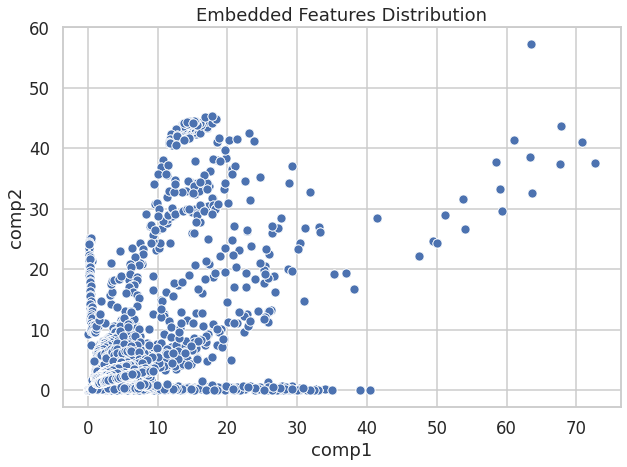

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Embedded Features Distribution')
sns.scatterplot(embedded.iloc[:,0], embedded.iloc[:,1], cmap=plt.get_cmap('Paired'))
plt.show()

<b> 밀도 기반 군집화 모델 : DBSCAN

In [ ]:
dbscan = DBSCAN(eps = 12, min_samples=200, metric='euclidean')
dbscan_labels = dbscan.fit_predict(embedded)

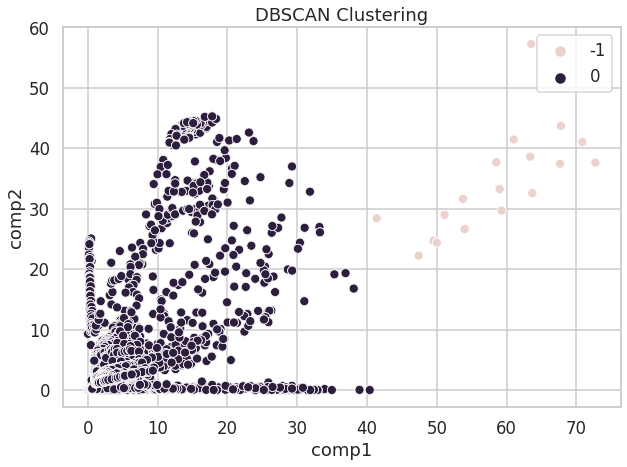

In [ ]:
plt.figure(figsize=(10,7))
plt.title('DBSCAN Clustering')
sns.scatterplot(embedded.iloc[:,0], embedded.iloc[:,1], hue=dbscan_labels)
plt.show()

In [ ]:
embedded['label'] = dbscan_labels
print('embedded.shape :',embedded.shape)
embedded.head()

embedded.shape : (10035, 3)


comp1     comp2  label
0  0.471057  0.138740      0
1  0.471057  0.138740      0
2  0.471057  0.138740      0
3  0.413232  0.138652      0
4  0.413232  0.138652      0

In [ ]:
cluster = embedded[embedded['label'] == 0 ].drop('label',axis=1)
print('cluster.shape :',cluster.shape)
cluster.head()

cluster.shape : (9981, 2)


comp1     comp2
0  0.471057  0.138740
1  0.471057  0.138740
2  0.471057  0.138740
3  0.413232  0.138652
4  0.413232  0.138652

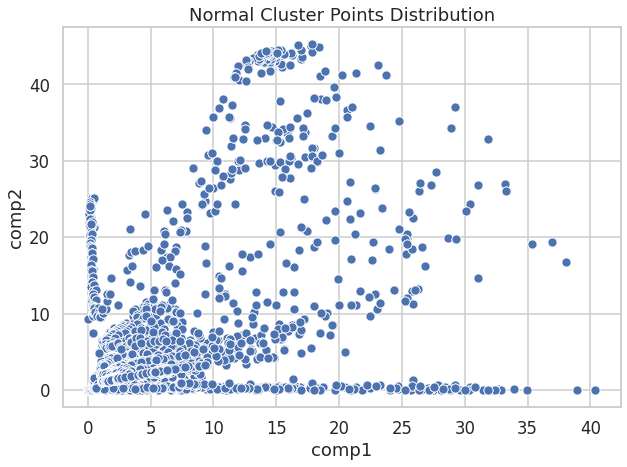

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Normal Cluster Points Distribution')
sns.scatterplot(cluster.iloc[:,0], cluster.iloc[:,1], cmap=plt.get_cmap('Paired'))
plt.show()

### OC-SVM

In [ ]:
oc_svm = OneClassSVM(gamma='scale', kernel='rbf', max_iter=1000, nu=0.05, verbose=True)
oc_svm.fit(cluster[['comp1','comp2']])

[LibSVM]

OneClassSVM(max_iter=1000, nu=0.05, verbose=True)

In [ ]:
cluster['label'] = oc_svm.predict(cluster[['comp1','comp2']])
cluster['label'] = np.array([0,0,1])[cluster['label'].values]
print(cluster['label'].value_counts())
cluster.head(1)

0    9483
1     498
Name: label, dtype: int64


comp1    comp2  label
0  0.471057  0.13874      0

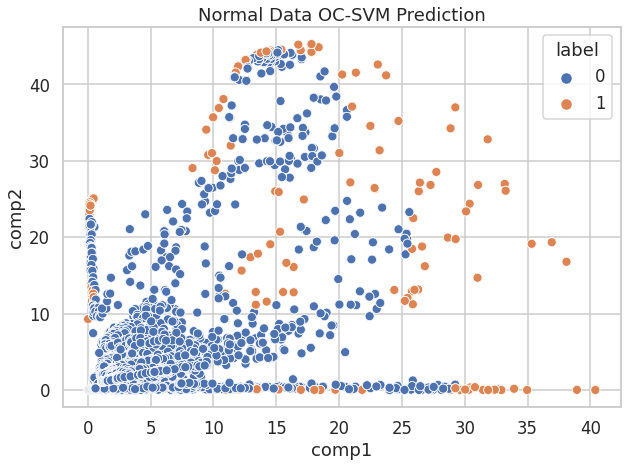

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Normal Data OC-SVM Prediction')
sns.scatterplot(cluster.iloc[:,0], cluster.iloc[:,1], cmap=plt.get_cmap('Paired'), hue=cluster.iloc[:,2])
plt.show()

In [ ]:
test_feature = pd.DataFrame(encoder.predict(test).reshape(-1,4))
test_feature.head(10)

0         1         2         3
0  6.373239  1.769982  2.221431  1.158109
1  6.373239  1.769982  2.221431  1.158109
2  6.373239  1.769982  2.221431  1.158109
3  5.629202  1.694761  2.206161  1.226638
4  5.629202  1.694761  2.206161  1.226638
5  5.629202  1.694761  2.206161  1.226638
6  5.161959  1.616628  2.117291  1.211541
7  5.161959  1.616628  2.117291  1.211541
8  5.161959  1.616628  2.117291  1.211541
9  6.384722  1.726955  2.130422  1.088098

In [ ]:
test_feature = test_feature.iloc[:,[0,2]].rename(columns={0:'comp1',2:'comp2'})
test_feature.index = test_score.index
print('test_feature.shape :',test_feature.shape)
test_feature.head()

test_feature.shape : (2646, 2)


comp1     comp2
Time                                
2022-05-15 17:00  6.373239  2.221431
2022-05-15 17:02  6.373239  2.221431
2022-05-15 17:04  6.373239  2.221431
2022-05-15 17:06  5.629202  2.206161
2022-05-15 17:08  5.629202  2.206161

In [ ]:
test_feature['DCC_score'] = oc_svm.score_samples(test_feature[['comp1','comp2']])
test_feature['distance'] = oc_svm.decision_function(test_feature[['comp1','comp2']])
test_feature['DCC_label'] = oc_svm.predict(test_feature[['comp1','comp2']])
test_feature['DCC_label'] = np.array([0,0,1])[test_feature['DCC_label'].values]
test_feature.head()

comp1     comp2  DCC_score  distance  DCC_label
Time                                                                
2022-05-15 17:00  6.373239  2.221431   3.886888  0.299500          0
2022-05-15 17:02  6.373239  2.221431   3.886888  0.299500          0
2022-05-15 17:04  6.373239  2.221431   3.886888  0.299500          0
2022-05-15 17:06  5.629202  2.206161   3.908650  0.321262          0
2022-05-15 17:08  5.629202  2.206161   3.908650  0.321262          0

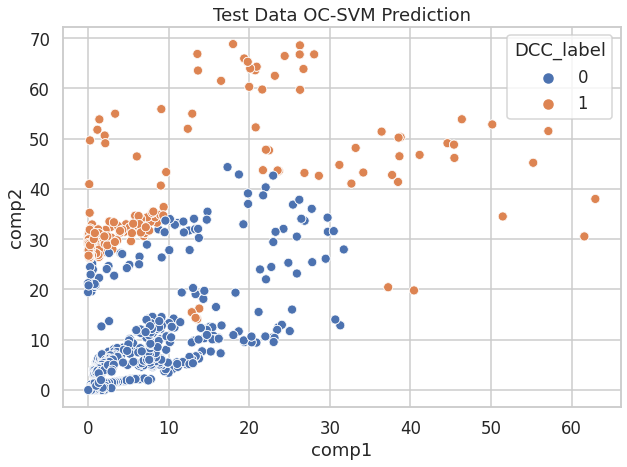

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Test Data OC-SVM Prediction')
sns.scatterplot(test_feature['comp1'], test_feature['comp2'], cmap=plt.get_cmap('Paired'), hue=test_feature['DCC_label'])
plt.show()

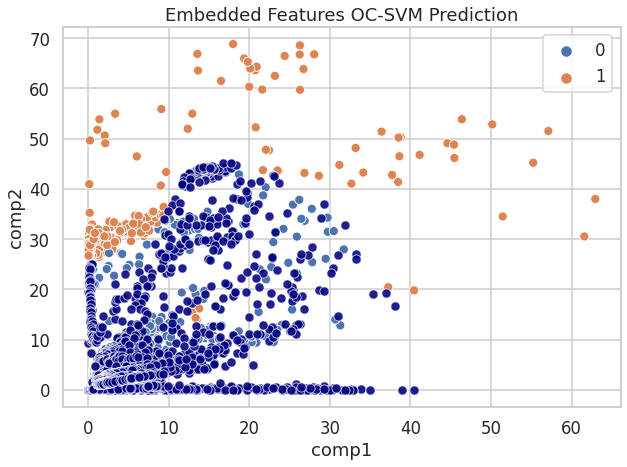

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Embedded Features OC-SVM Prediction')
sns.scatterplot(test_feature['comp1'], test_feature['comp2'], cmap=plt.get_cmap('Paired'), hue=test_feature['DCC_label'])
sns.scatterplot(cluster['comp1'], cluster['comp2'], cmap=plt.get_cmap('Paired'), color='navy', alpha=0.5)
plt.show()

In [ ]:
# OC-SVM Model Save
filename = 'oc_svm_model_save/OC-SVM_model.sav'
pickle.dump(oc_svm, open(filename, 'wb'))

In [ ]:
# OC-SVM Model Load
oc_svm = pickle.load(open(filename, 'rb'))

### Decision Rule Definition

<b> 1. Reconstruction Error Based Model

In [ ]:
RE_model = lstm_ae_model

In [ ]:
test_score['RE_label'] = (test_score['RE_SCORE'] > train_boundary).astype('int')
re_score = test_feature[['comp1','comp2']]
re_score = pd.concat([re_score,test_score[['RE_SCORE','RE_label']]],axis=1)
print(re_score.shape)
re_score.head()

(2646, 4)


comp1     comp2  RE_SCORE  RE_label
Time                                                    
2022-05-15 17:00  6.373239  2.221431  0.019737         0
2022-05-15 17:02  6.373239  2.221431  0.003490         0
2022-05-15 17:04  6.373239  2.221431  0.002443         0
2022-05-15 17:06  5.629202  2.206161  0.002653         0
2022-05-15 17:08  5.629202  2.206161  0.004384         0

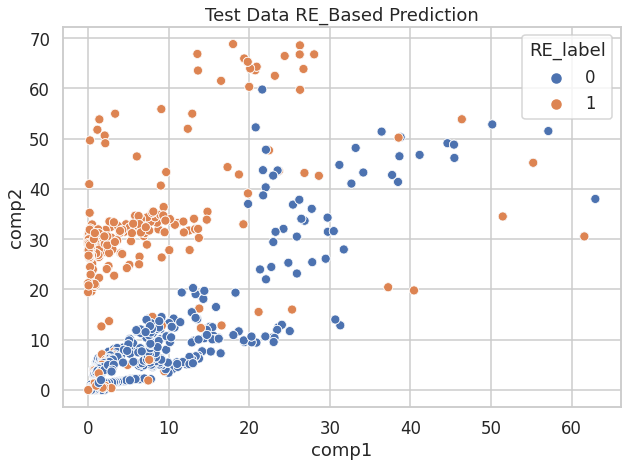

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Test Data RE_Based Prediction')
sns.scatterplot(re_score['comp1'], re_score['comp2'], cmap=plt.get_cmap('Paired'), hue=re_score['RE_label'])
plt.show()

<b> 2. DCC OC-SVM Based Model

In [ ]:
DCC_model = oc_svm

In [ ]:
dcc_score = test_feature
dcc_score.index = test_score.index
print(dcc_score.shape)
dcc_score.head()

(2646, 5)


comp1     comp2  DCC_score  distance  DCC_label
Time                                                                
2022-05-15 17:00  6.373239  2.221431  81.218837  1.831649          0
2022-05-15 17:02  6.373239  2.221431  81.218837  1.831649          0
2022-05-15 17:04  6.373239  2.221431  81.218837  1.831649          0
2022-05-15 17:06  5.629202  2.206161  81.097323  1.710135          0
2022-05-15 17:08  5.629202  2.206161  81.097323  1.710135          0

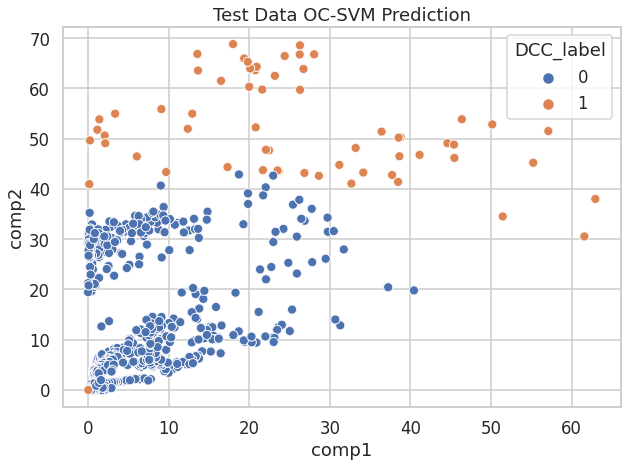

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Test Data OC-SVM Prediction')
sns.scatterplot(dcc_score['comp1'], dcc_score['comp2'], cmap=plt.get_cmap('Paired'), hue=dcc_score['DCC_label'])
plt.show()

<b> 3. DCC LSTM-AE Model

In [ ]:
vote_score = pd.concat([re_score, dcc_score[['DCC_score','distance','DCC_label']]],axis=1)
print('vote_score.shape :',vote_score.shape)
vote_score.head()

vote_score.shape : (2646, 7)


comp1     comp2  RE_SCORE  RE_label  DCC_score  distance  \
Time                                                                            
2022-05-15 17:00  6.373239  2.221431  0.019737         0  81.218837  1.831649   
2022-05-15 17:02  6.373239  2.221431  0.003490         0  81.218837  1.831649   
2022-05-15 17:04  6.373239  2.221431  0.002443         0  81.218837  1.831649   
2022-05-15 17:06  5.629202  2.206161  0.002653         0  81.097323  1.710135   
2022-05-15 17:08  5.629202  2.206161  0.004384         0  81.097323  1.710135   

                  DCC_label  
Time                         
2022-05-15 17:00          0  
2022-05-15 17:02          0  
2022-05-15 17:04          0  
2022-05-15 17:06          0  
2022-05-15 17:08          0

In [ ]:
print(vote_score['RE_label'].value_counts())
print(vote_score['DCC_label'].value_counts())
print(((vote_score['RE_label'] > 0 )  | (vote_score['DCC_label'] > 0)).value_counts())
print(((vote_score['RE_label'] > 0 )  & (vote_score['DCC_label'] > 0)).value_counts())

0    1881
1     765
Name: RE_label, dtype: int64
0    2463
1     183
Name: DCC_label, dtype: int64
False    1811
True      835
dtype: int64
False    2533
True      113
dtype: int64


In [ ]:
vote_score['Hard Vote OR'] = ((vote_score['RE_label'] > 0 )  | (vote_score['DCC_label'] > 0)).astype(int)
vote_score['Hard Vote AND'] = ((vote_score['RE_label'] > 0 )  & (vote_score['DCC_label'] > 0)).astype(int)
vote_score.head(1)

comp1     comp2  RE_SCORE  RE_label  DCC_score  distance  \
Time                                                                            
2022-05-15 17:00  6.373239  2.221431  0.019737         0  81.218837  1.831649   

                  DCC_label  Hard Vote OR  Hard Vote AND  
Time                                                      
2022-05-15 17:00          0             0              0

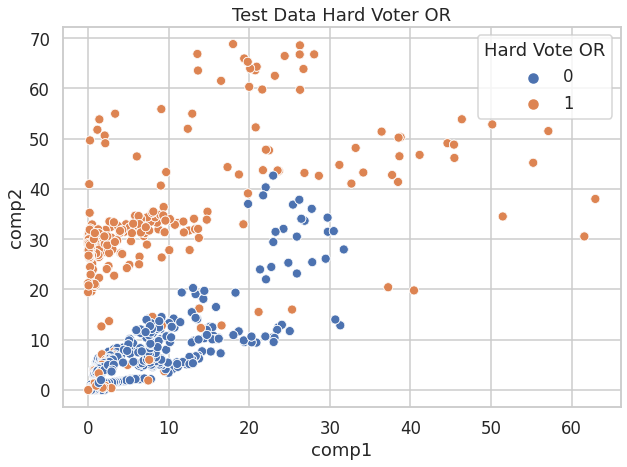

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Test Data Hard Voter OR')
sns.scatterplot(vote_score['comp1'], vote_score['comp2'], cmap=plt.get_cmap('Paired'), hue=vote_score['Hard Vote OR'])
plt.show()

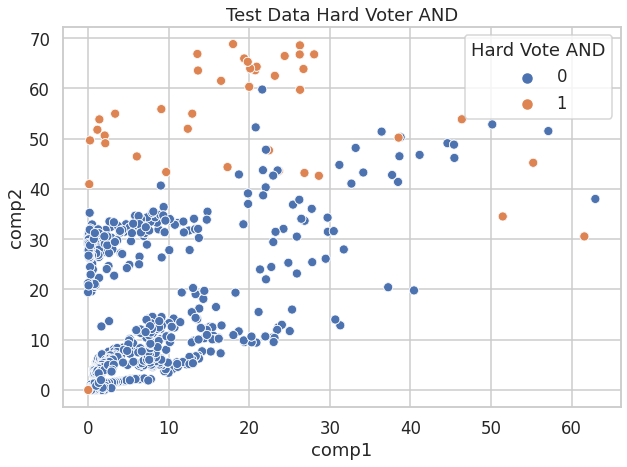

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Test Data Hard Voter AND')
sns.scatterplot(vote_score['comp1'], vote_score['comp2'], cmap=plt.get_cmap('Paired'), hue=vote_score['Hard Vote AND'])
plt.show()

## 4. Simulation

### Simultation Data Preprocessing

In [ ]:
print(df11.shape)
df11.head(2)

(13237, 7)


Temperature  Humidity    TVOC    CO    CO2  CH2O  PM10
Time                                                                    
2022-05-01 00:02        23.27     21.45  1377.0  0.82  545.0  25.0  18.0
2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0  19.0

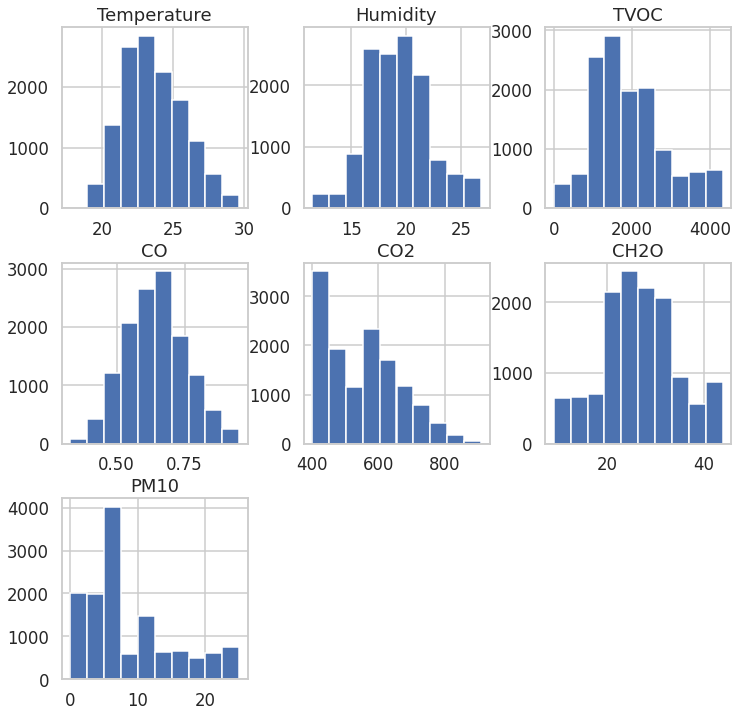

In [ ]:
df11.hist(figsize=(12,12))
plt.show()

In [ ]:
simul_df = pd.read_csv('data/simul_preprocessed.csv',index_col='TsYMD')
simul_df.index.name = 'Time'
print('simul_df.shape :',simul_df.shape)

simul_df.shape : (4619, 7)


In [ ]:
print('Missing Value :',simul_df.isna().sum().sum())
simul_df.head(1)

Missing Value : 0


Temperature  Humidity    TVOC    CO    CO2  CH2O  PM10
Time                                                                       
2022-07-13 00:01:06        22.63     36.52  2424.0  0.69  600.0  55.0   5.0

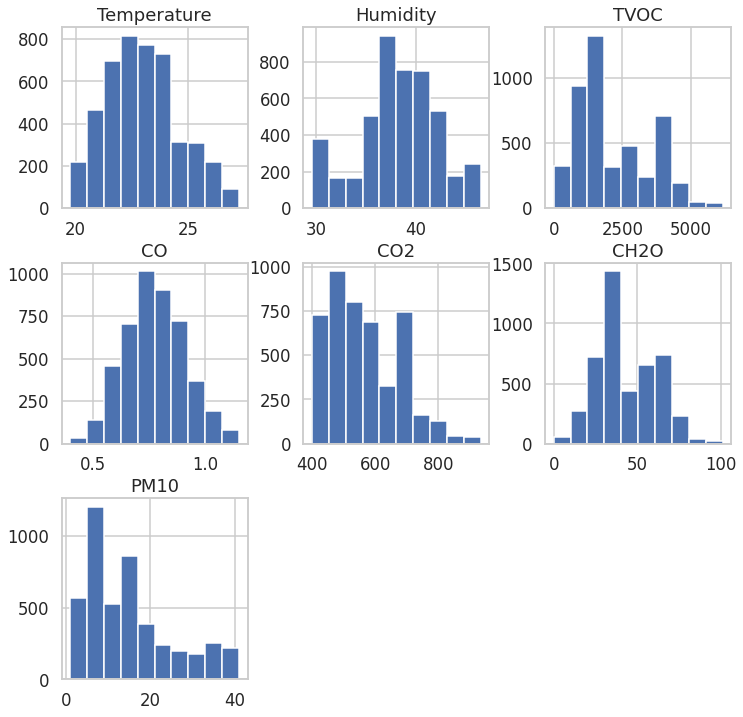

In [ ]:
simul_df.hist(figsize=(12,12))
plt.show()

(0.0, 2000.0)

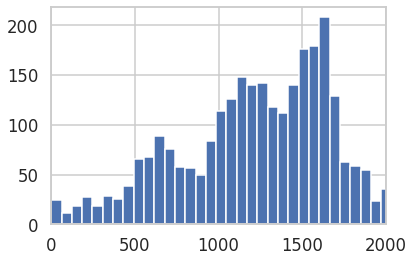

In [ ]:
plt.hist(simul_df['TVOC'],bins=100)
plt.xlim([0,2000])

In [ ]:
simul_df['CH2O'].sort_values().value_counts()

37.0    270
62.0    236
36.0    209
61.0    195
35.0    181
       ... 
2.0       2
94.0      1
89.0      1
97.0      1
99.0      1
Name: CH2O, Length: 102, dtype: int64

In [ ]:
simul_len = simul_df.shape[0]

In [ ]:
simul_df.head(1)

Temperature  Humidity    TVOC    CO    CO2  CH2O  PM10
Time                                                                       
2022-07-13 00:01:06        22.63     36.52  2424.0  0.69  600.0  55.0   5.0

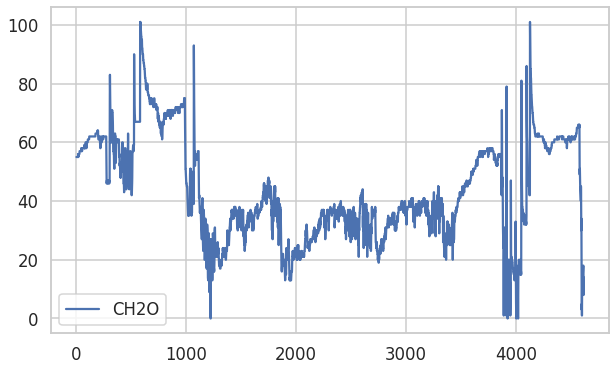

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(np.arange(simul_len),simul_df['CH2O'].values, label='CH2O')
plt.show()

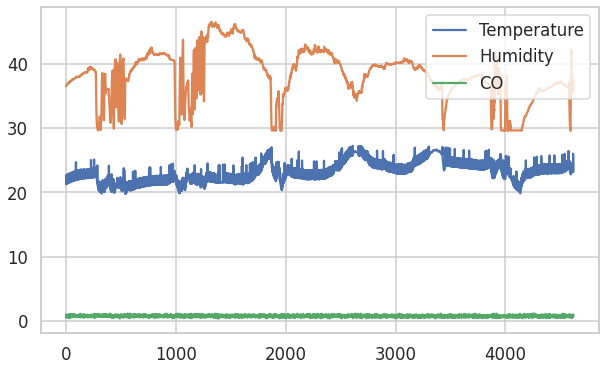

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(np.arange(simul_len),simul_df['Temperature'].values, label='Temperature')
sns.lineplot(np.arange(simul_len),simul_df['Humidity'].values, label='Humidity')
sns.lineplot(np.arange(simul_len),simul_df['CO'].values, label='CO')
plt.show()

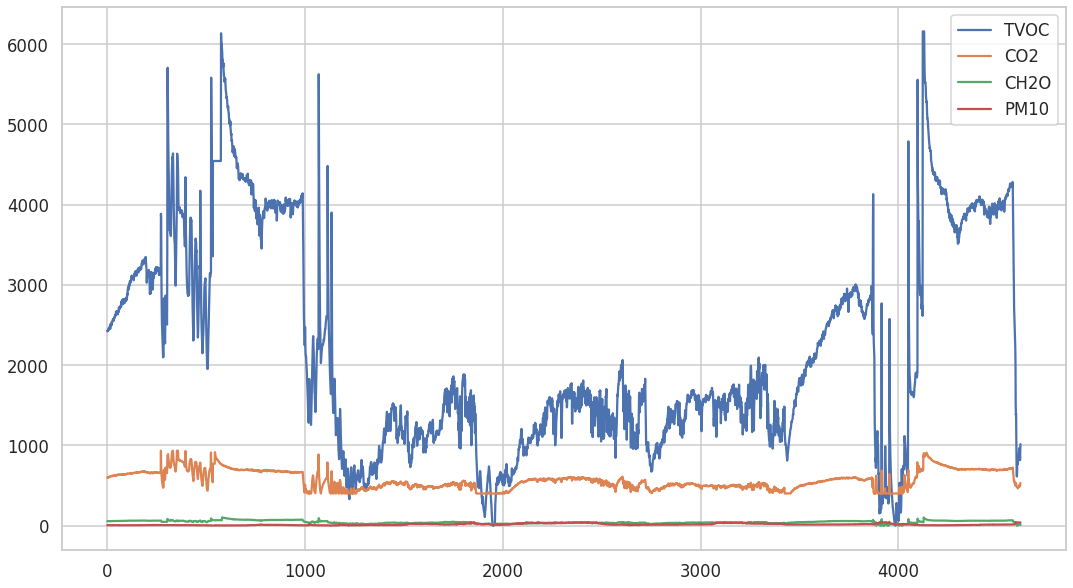

In [ ]:
plt.figure(figsize=(18,10))
sns.lineplot(np.arange(simul_len),simul_df['TVOC'].values, label='TVOC')
sns.lineplot(np.arange(simul_len),simul_df['CO2'].values, label='CO2')
sns.lineplot(np.arange(simul_len),simul_df['CH2O'].values, label='CH2O')
sns.lineplot(np.arange(simul_len),simul_df['PM10'].values, label='PM10')
plt.show()

In [ ]:
simul_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4619 entries, 2022-07-13 00:01:06 to 2022-07-19 10:02:32
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  4619 non-null   float64
 1   Humidity     4619 non-null   float64
 2   TVOC         4619 non-null   float64
 3   CO           4619 non-null   float64
 4   CO2          4619 non-null   float64
 5   CH2O         4619 non-null   float64
 6   PM10         4619 non-null   float64
dtypes: float64(7)
memory usage: 417.7+ KB


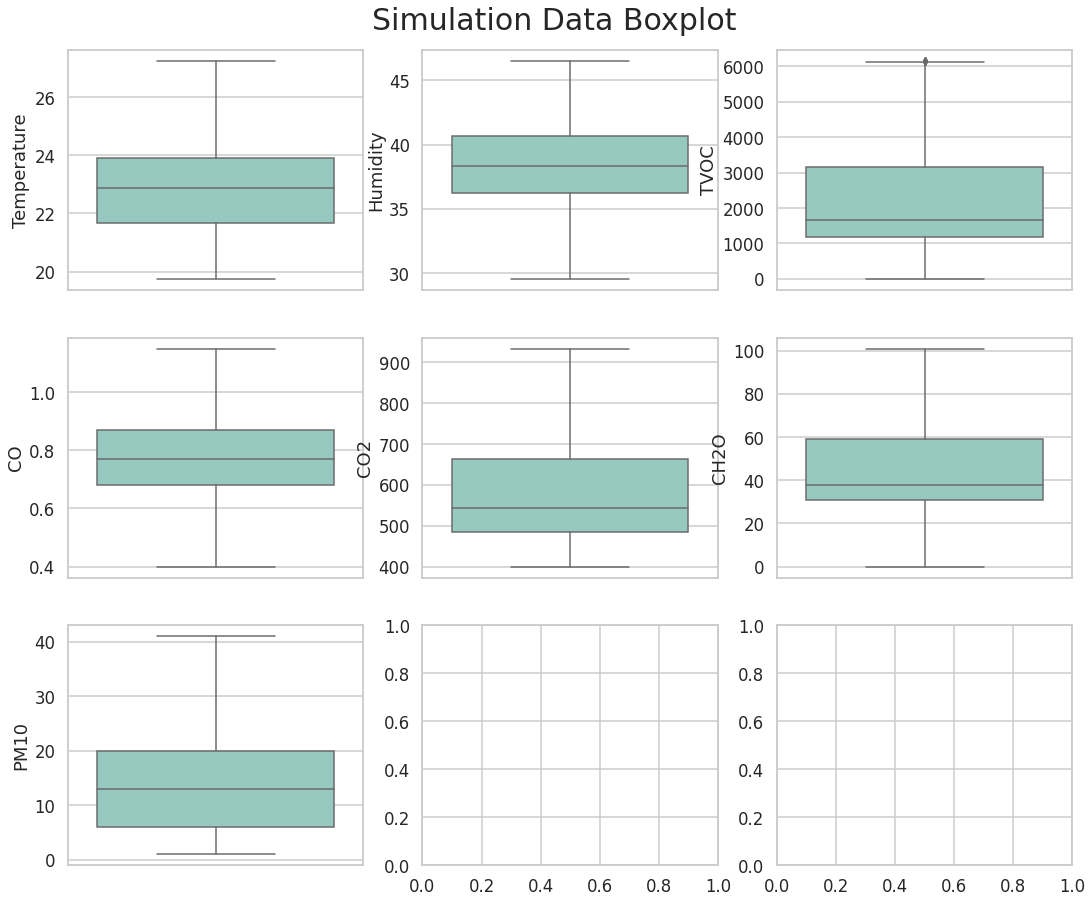

In [ ]:
boxplotEDA(simul_df,simul_df.columns,3,3, 'Simulation Data Boxplot')

In [ ]:
simul_norm = MinMaxScaler()
X_simul = simul_norm.fit_transform(simul_df)
print('X_simul.shape :',X_simul.shape)

X_simul.shape : (4619, 7)


In [ ]:
simul_size = int(X_simul.shape[0]/3)*3
simul_size

4617

In [ ]:
X_simul = np.reshape(X_simul[:simul_size], (-1,3,7))
print('X_simul.shape :',X_simul.shape)

X_simul.shape : (1539, 3, 7)


### Simulation Data Reconstruction Error

In [ ]:
og_train.head()

Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.428571  0.651133  0.317867  0.790323  0.285996   
2022-05-01 00:04     0.180593  0.651780  0.317867  0.790323  0.284024   
2022-05-01 00:06     0.302785  0.651780  0.319252  0.274194  0.287968   
2022-05-01 00:08     0.302785  0.653074  0.317175  0.306452  0.289941   
2022-05-01 00:10     0.301887  0.653074  0.318560  0.064516  0.291913   

                      CH2O  PM10  
Time                              
2022-05-01 00:02  0.457143  0.72  
2022-05-01 00:04  0.457143  0.76  
2022-05-01 00:06  0.457143  0.72  
2022-05-01 00:08  0.457143  0.72  
2022-05-01 00:10  0.457143  0.72

In [ ]:
# Original Simulation DataSet
og_simul = pd.DataFrame(X_simul.reshape(-1,7), columns = simul_df.columns)
og_simul.index = simul_df[:simul_size].index
og_simul.head()

Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                       
2022-07-13 00:01:06     0.384000  0.410029  0.393570  0.386667  0.374532   
2022-07-13 00:03:06     0.385333  0.411799  0.393083  0.400000  0.378277   
2022-07-13 00:05:06     0.204000  0.413569  0.394707  0.813333  0.370787   
2022-07-13 00:07:06     0.205333  0.416519  0.394220  0.240000  0.376404   
2022-07-13 00:09:06     0.208000  0.417699  0.396331  0.200000  0.380150   

                         CH2O   PM10  
Time                                  
2022-07-13 00:01:06  0.544554  0.100  
2022-07-13 00:03:06  0.544554  0.100  
2022-07-13 00:05:06  0.544554  0.100  
2022-07-13 00:07:06  0.544554  0.075  
2022-07-13 00:09:06  0.544554  0.100

In [ ]:
# Prediction of Simul DataSet
X_pred_simul = lstm_ae_model.predict(X_simul)

simul_pred = X_pred_simul.reshape(-1, X_pred_simul.shape[2])
simul_pred = pd.DataFrame(simul_pred, columns = simul_df.columns)
simul_pred.index = simul_df[:simul_size].index
print('simul_pred.shape :',simul_pred.shape)
simul_pred.head()

simul_pred.shape : (4617, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                       
2022-07-13 00:01:06     0.448849  0.483889  0.424318  0.497016  0.217576   
2022-07-13 00:03:06     0.445285  0.477103  0.428454  0.498097  0.214043   
2022-07-13 00:05:06     0.438575  0.476824  0.429589  0.499434  0.211826   
2022-07-13 00:07:06     0.378778  0.547290  0.418464  0.505792  0.202940   
2022-07-13 00:09:06     0.380649  0.541639  0.421670  0.506668  0.201010   

                         CH2O      PM10  
Time                                     
2022-07-13 00:01:06  0.563553  0.172514  
2022-07-13 00:03:06  0.571977  0.168366  
2022-07-13 00:05:06  0.572928  0.164224  
2022-07-13 00:07:06  0.577683  0.161701  
2022-07-13 00:09:06  0.582892  0.158999

In [ ]:
# Simul data Reconstruction Error
simul_score = RE_SCORE(og_simul, simul_pred)
simul_score = simul_score.set_index(simul_score.index)
simul_score.head()

RE_SCORE
Time                         
2022-07-13 00:01:06  0.007577
2022-07-13 00:03:06  0.007305
2022-07-13 00:05:06  0.026996
2022-07-13 00:07:06  0.022446
2022-07-13 00:09:06  0.025271

In [ ]:
# Simul Data Reconstruction Error Threshold
upper, lower= np.quantile(simul_score['RE_SCORE'].values,0.75), np.quantile(simul_score['RE_SCORE'].values,0.25)
iqr = upper-lower
simul_boundary = upper + iqr*1.5
print('Simul Data IQR Based boundary :',np.round(simul_boundary,4))

Simul Data IQR Based boundary : 0.0574


In [ ]:
simul_score['Threshold'] = train_boundary
simul_score.head()

RE_SCORE  Threshold
Time                                    
2022-07-13 00:01:06  0.007577   0.031509
2022-07-13 00:03:06  0.007305   0.031509
2022-07-13 00:05:06  0.026996   0.031509
2022-07-13 00:07:06  0.022446   0.031509
2022-07-13 00:09:06  0.025271   0.031509

In [ ]:
simul_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4617 entries, 2022-07-13 00:01:06 to 2022-07-19 09:58:32
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RE_SCORE   4617 non-null   float64
 1   Threshold  4617 non-null   float64
dtypes: float64(2)
memory usage: 108.2+ KB


In [ ]:
# Reconstruction Error of Simul Data
fig = px.scatter(simul_score, x=simul_score.index, y='RE_SCORE', title='Reconstruction Error of Simul Set')
fig.add_trace(go.Scatter(x=simul_score.index, y=simul_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color=('rgb(237,37,75)'))))

In [ ]:
# Reconstruction Error Distribution of Simul Data
fig = px.histogram(simul_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Simul Data', marginal='box')
fig.add_vline(x=simul_boundary, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(simul_boundary,4)), annotation_position="bottom right")
fig.show()

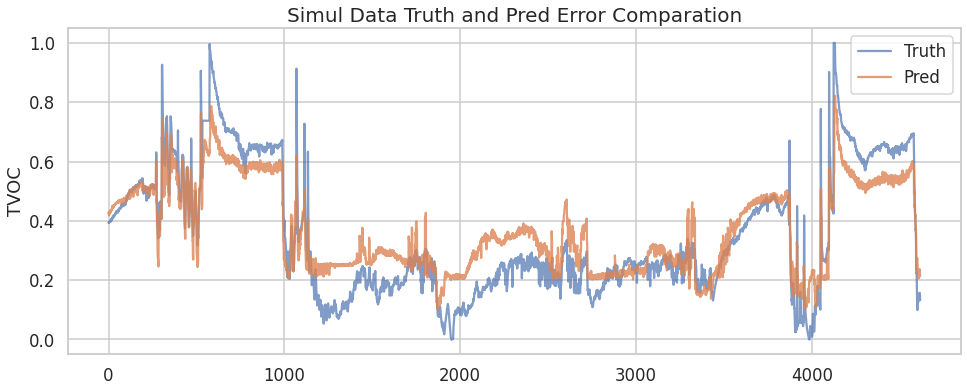

In [ ]:
# Simul Data Truth and Pred Error Comparation
plt.figure(figsize=(16,6))
sns.lineplot(np.arange(simul_size), og_simul['TVOC'], alpha=0.7, label='Truth')
sns.lineplot(np.arange(simul_size), simul_pred['TVOC'], alpha=0.8, label='Pred')
plt.title('Simul Data Truth and Pred Error Comparation',size=20)
plt.legend(loc='upper right')
plt.show()

### Simulation Data Clustering

In [ ]:
embedded_simul = pd.DataFrame(encoder.predict(X_simul).reshape(-1,4))
embedded_simul.head(1)

0         1         2         3
0  2.156665  1.657965  2.847245  2.436065

In [ ]:
embedded_simul = embedded_simul.iloc[:,[0,2]].rename(columns={0:'comp1',2:'comp2'})
print('embedded_simul.shape :',embedded_simul.shape)
embedded_simul.head()

embedded_simul.shape : (4617, 2)


comp1     comp2
0  2.156665  2.847245
1  2.156665  2.847245
2  2.156665  2.847245
3  1.213726  2.517184
4  1.213726  2.517184

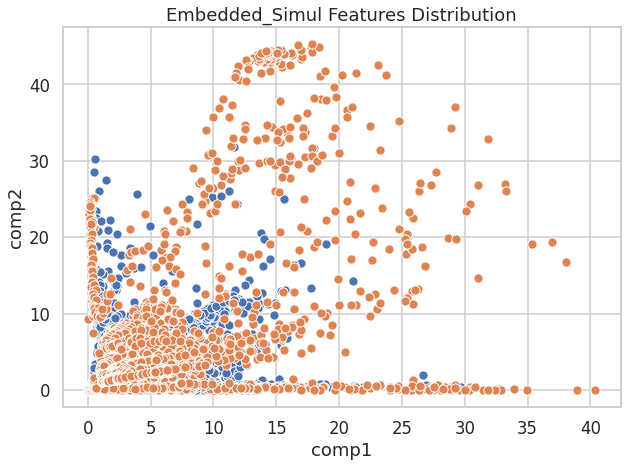

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Embedded_Simul Features Distribution')
sns.scatterplot(embedded_simul.iloc[:,0], embedded_simul.iloc[:,1], cmap=plt.get_cmap('Paired'))
sns.scatterplot(cluster.iloc[:,0], cluster.iloc[:,1], cmap=plt.get_cmap('Paired'))
# plt.xlim(0,25)
# plt.ylim(0,50)
plt.show()

### Simulation Data Decision Rule Apply

In [ ]:
embedded_simul.index = simul_score.index
simul_score['comp1'] = embedded_simul['comp1']
simul_score['comp2'] = embedded_simul['comp2']
simul_score['RE_label'] = (simul_score['RE_SCORE'] > simul_score['Threshold']).astype('int')
simul_score.head()

RE_SCORE  Threshold     comp1     comp2  RE_label
Time                                                                  
2022-07-13 00:01:06  0.007577   0.031509  2.156665  2.847245         0
2022-07-13 00:03:06  0.007305   0.031509  2.156665  2.847245         0
2022-07-13 00:05:06  0.026996   0.031509  2.156665  2.847245         0
2022-07-13 00:07:06  0.022446   0.031509  1.213726  2.517184         0
2022-07-13 00:09:06  0.025271   0.031509  1.213726  2.517184         0

In [ ]:
simul_score['RE_label'].value_counts()

0    3603
1    1014
Name: RE_label, dtype: int64

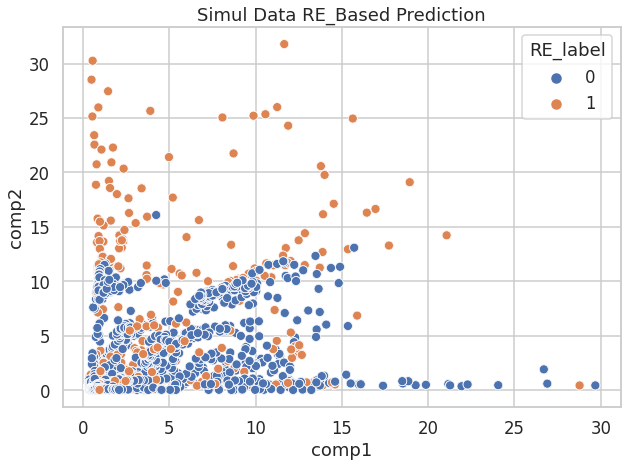

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Simul Data RE_Based Prediction')
sns.scatterplot(simul_score['comp1'], simul_score['comp2'], cmap=plt.get_cmap('Paired'), hue=simul_score['RE_label'])
plt.show()

In [ ]:
embedded_simul['DCC_score'] = oc_svm.score_samples(embedded_simul[['comp1','comp2']])
embedded_simul['distance'] = oc_svm.decision_function(embedded_simul[['comp1','comp2']])
embedded_simul['DCC_label'] = oc_svm.predict(embedded_simul[['comp1','comp2']])
embedded_simul['DCC_label'] = np.array([0,0,1])[embedded_simul['DCC_label'].values]
embedded_simul.head()

comp1     comp2  DCC_score  distance  DCC_label
Time                                                                   
2022-07-13 00:01:06  2.156665  2.847245  80.590223  1.203035          0
2022-07-13 00:03:06  2.156665  2.847245  80.590223  1.203035          0
2022-07-13 00:05:06  2.156665  2.847245  80.590223  1.203035          0
2022-07-13 00:07:06  1.213726  2.517184  80.300931  0.913743          0
2022-07-13 00:09:06  1.213726  2.517184  80.300931  0.913743          0

In [ ]:
embedded_simul['DCC_label'].value_counts()

0    4617
Name: DCC_label, dtype: int64

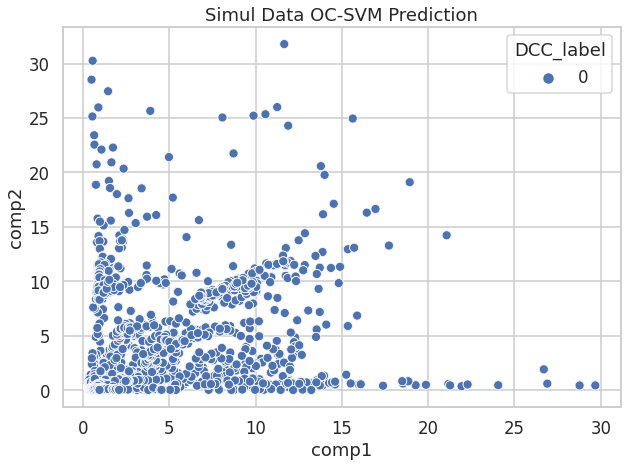

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Simul Data OC-SVM Prediction')
sns.scatterplot(embedded_simul['comp1'], embedded_simul['comp2'], cmap=plt.get_cmap('Paired'), hue=embedded_simul['DCC_label'])
plt.show()

In [ ]:
vote_score.head()

comp1     comp2  RE_SCORE  RE_label  DCC_score  distance  \
Time                                                                            
2022-05-15 17:00  6.373239  2.221431  0.019737         0  81.218837  1.831649   
2022-05-15 17:02  6.373239  2.221431  0.003490         0  81.218837  1.831649   
2022-05-15 17:04  6.373239  2.221431  0.002443         0  81.218837  1.831649   
2022-05-15 17:06  5.629202  2.206161  0.002653         0  81.097323  1.710135   
2022-05-15 17:08  5.629202  2.206161  0.004384         0  81.097323  1.710135   

                  DCC_label  Hard Vote OR  Hard Vote AND  
Time                                                      
2022-05-15 17:00          0             0              0  
2022-05-15 17:02          0             0              0  
2022-05-15 17:04          0             0              0  
2022-05-15 17:06          0             0              0  
2022-05-15 17:08          0             0              0